In [1]:
from __future__ import annotations

import sys
from pathlib import Path
import matplotlib.pyplot as plt


def find_root_dir(current_path: Path | None = None, marker: str = '.git') -> Path | None:
    """
    Find the root directory by searching for a directory or file that serves as a
    marker.

    Parameters
    ----------
    current_path : Path | None
        The starting path to search from. If None, the current working directory
        `Path.cwd()` is used.
    marker : str
        The name of the file or directory that signifies the root.

    Returns
    -------
    Path | None
        The path to the root directory. Returns None if the marker is not found.
    """
    if not current_path:
        current_path = Path.cwd()
    current_path = current_path.resolve()
    for parent in [current_path, *current_path.parents]:
        if (parent / marker).exists():
            return parent
    return None

root_dir = find_root_dir(marker='omnivault')

if root_dir is not None:
    sys.path.append(str(root_dir))
    from omnivault.utils.visualization.style import use_svg_display
else:
    raise ImportError("Root directory not found.")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS

use_svg_display()

# Concept

```{contents}
```

This section details the linear regression model from a probabilistic perspective.


## Intuition

As a running example, suppose that we wish
to estimate the prices of houses (in dollars)
based on their area (in square feet) and age (in years).
To develop a model for predicting house prices,
we need to get our hands on data consisting of sales,
including the sales price, area, and age for each home.
In the terminology of machine learning,
the dataset is called a *training dataset* or *training set*,
and each row (containing the data corresponding to one sale)
is called an *example* (or *data point*, *instance*, *sample*).
The thing we are trying to predict (price)
is called a *label* (or *target*).
The variables (age and area)
upon which the predictions are based
are called *features* (or *covariates*) {cite}`zhang2023dive`.

Let's create a housing dataset below with $100$ samples.

In [2]:
# Set the random seed for reproducibility
np.random.seed(42)

# Generate random data for the features and the target variable
n_samples = 100
house_size = np.random.randint(100, size=n_samples)
age = np.random.randint(50, size=n_samples)
price = 100000 + 1000 * house_size + 500 * age + np.random.normal(0, 10000, size=n_samples)
price = price.astype(int)

# Create a Pandas DataFrame to store the data
data = pd.DataFrame({'House Size (sqft)': house_size, 'Age (years)': age, 'Price ($)': price})

# Print the first few rows of the DataFrame
display(data)

,House Size (sqft),Age (years),Price ($)
0,51,25,163551
1,92,24,201654
2,14,44,121846
3,71,40,186793
4,60,28,170572
...,...,...,...
95,84,0,171542
96,79,26,193731
97,81,12,190853
98,52,40,163161


The goal is to predict the price of a house given its size. We can visualize the
relationship between the house size and the price using a scatter plot.

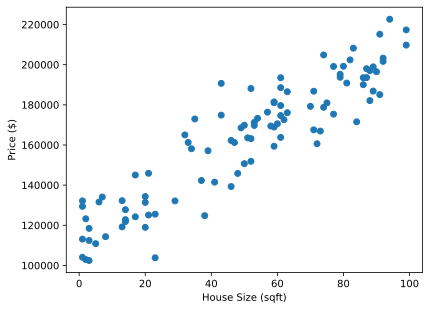

In [3]:
X = data['House Size (sqft)']
y = data['Price ($)']

plt.scatter(X, y)
plt.xlabel('House Size (sqft)')
plt.ylabel('Price ($)')
plt.show()

### Univariate Linear Model

Let's try to model the relationship between the house size (sqft) and the price ($). The assumption of linearity means that the expected value of the target (price) can be expressed as a
linear function of the feature (sqft).

$$
\text{price} = \beta_0 + \beta_1 \cdot \text{sqft} \iff y = \beta_0 + \beta_1 x
$$ (eq_price-area)

where $\beta_0$ is the intercept, $\beta_1$ the coefficient, $x$ the feature (sqft) and $y$ the target (price).

Here the coefficient $\beta_1$ is called the *weights* and the intercept $\beta_0$ is called the *bias*.

The weights determine the influence of each feature on our prediction, this means that
a larger weight indicates that the feature is more important for predicting the target.

The bias determines the value of the estimate when all features are zero. Why do we need this?
Will there ever be a case where the house size (sqft) is $0$? No, but we still need the bias because it allows us
to express the functional/hypothesis space of linear functions (more on that later). Intuitively,
if there is no bias, the equation will always pass through the origin, which means that the model
can never vary up or down.

```{prf:remark} Why do we need a bias?
:label: prf:remark-bias

If there is no bias term in the model, you will lose the flexibility of your model. Imagine a simple linear regression model without a bias term, then your linear equation $y=mx$ will only pass through the origin. Therefore, if your underlying data (pretend that we know that the underlying data's actual function $y = 3x + 5$), then your Linear Regression model will never find the "best fit line" simply because we already assume that our prediction is governed by the slope $m$, and there does not exist our $c$, the intercept/bias term.
```

Therefore, it is usually the case whereby we always add in an intercept term. We intend to estimate the values of $y$ ***given*** $x$. Each value of $x$ is multiplied by $\beta_{1}$, with a constant intercept term $\beta_{0}$. We also note that $1$ unit increase in $x$ will correspond to a $\beta_1$ unit increase in $y$ according to the model, while always remebering to add the intercept term.

The equation {eq}`eq_price-area` is an [**affine transformation**](https://en.wikipedia.org/wiki/Affine_transformation) of the input features. The difference between an affine transformation and a linear transformation is that an affine transformation has a translation (bias) component. In other words,
an affine transformation is a linear transformation combined with a translation.

Our goal is to choose
the weights $\beta_1$ and the bias $\beta_0$ such that, on average, make our model's predictions
fit the true prices observed in the data as closely as possible {cite}`zhang2023dive`.
This also means being able to extrapolate to new data points that were not part of the training set.

For example, the best fit line for the data above is shown below.

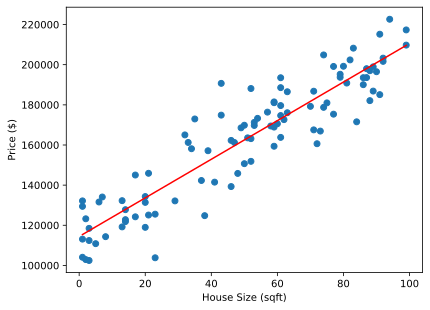

In [4]:
X = data['House Size (sqft)']
y = data['Price ($)']

plt.scatter(X, y)
plt.plot(np.unique(X), np.poly1d(np.polyfit(X, y, 1))(np.unique(X)), color='red')
plt.xlabel('House Size (sqft)')
plt.ylabel('Price ($)')
plt.show()

Our goal is to find that red line among all possible lines that best fits the data.


### Multivariate Linear Model

It is often the case that there are multiple
explanatory variables (features). As a continuation of the example above,
let's say that we want to predict the price of a house given its size and age, we
would then have the linear equation below.

$$
\text{price} = \beta_0 + \beta_1 \cdot \text{sqft} + \beta_2 \cdot \text{age} \iff y = \beta_0 + \beta_1 x_1 + \beta_2 x_2
$$ (eq_price-area-age)

where $\beta_0$ is the intercept, $\beta_1$ and $\beta_2$ the coefficients, $x_1$ and $x_2$ the features (sqft and age) and $y$ the target (price).

Then our task is to find the best values for the weights $\beta_1$ and $\beta_2$ and the bias $\beta_0$
such that the model's predictions are as close as possible to the true prices observed in the data.

### The Hypothesis Space

As with any machine learning problem, we need to define a hypothesis space $\mathcal{H}$, which is the set of all possible models that we consider. In the case of linear regression, the hypothesis space is the set of all possible linear functions.

$$
\mathcal{H} = \left\{ h \in \mathbb{R}^{D} \rightarrow \mathbb{R} \mid h\left(\mathbf{x}; \boldsymbol{\beta}\right) = \boldsymbol{\beta}^T \mathbf{x} + \beta_0 \text{ for some parameter/weight vector } \boldsymbol{\beta} \in \mathbb{R}^{D}\right\}
$$

where we specify

- $\mathbf{x} \in \mathbb{R}^{D}$ is the input vector,
- $\boldsymbol{\beta} \in \mathbb{R}^{D}$ is the weight vector,
- $\beta_0 \in \mathbb{R}$ is the bias,
- $h$ as a function of $\mathbf{x}$ and $\boldsymbol{\beta}$,
and we put $\boldsymbol{\beta}$ after $;$ to indicate that $h$ is parameterized by $\boldsymbol{\beta}$.

We will explain them in more detail in the next few sections.

### The Loss Function

Once we have defined our hypothesis, we need to define a loss function $\mathcal{L}$ that measures how good a given hypothesis $h$ is.

The loss in the case of linear regression is usually the [**mean squared error loss**](https://en.wikipedia.org/wiki/Mean_squared_error) (MSE),
which we will use in this section.

$$
\mathcal{L} = \mathbb{E}_{\mathbf{x}, y \sim \mathcal{D}}\left[\left(y - h\left(\mathbf{x}; \boldsymbol{\beta}\right)\right)^{2}\right]
$$

and via the ERM framework we deal with empirical loss $\widehat{\mathcal{L}}$
which we will make precise later.

## Problem Formulation

The main formulation is formulated based on Foundations of Machine Learning {cite}`mohri_ameet_2018`.

Consider $\mathcal{X}$ as our input space, usually $\mathbb{R}^{D}$, and $\mathcal{Y}$ a measurable subset of $\mathbb{R}$,
we adopt the probablistic framework and denote $\mathbb{P}_{\mathcal{D}}$ as the probability distribution over $\mathcal{X} \times \mathcal{Y}$.
The deterministic scenario is merely a special case where $\mathbb{P}_{\mathcal{D}}$ is a Dirac delta function[^dirac-delta], and that we have
a ground truth function $f: \mathcal{X} \rightarrow \mathcal{Y}$ that uniquely determines the
target $y \in \mathcal{Y}$ for any input $\mathbf{x} \in \mathcal{X}$.

Then the linear regression model has the following form:

$$
\left|
\begin{array}{l}
y := f\left(\mathbf{x}\right) + \varepsilon = \beta_0 + \boldsymbol{\beta}^T \mathbf{x} + \varepsilon \\
 \boldsymbol{\varepsilon} \overset{\small{\text{i.i.d.}}}{\sim} \mathcal{N}(0, \sigma^2) \\
\end{array}
\right.
$$ (eq-linear-regression-1)

where

- $\varepsilon$ is a random variable drawn $i.i.d.$ from a zero-mean Gaussian distribution with variance $\sigma^2$
- $f$ is the **unknown** ground truth linear function of the parameters $\boldsymbol{\beta}$.

To be more precise, the $\varepsilon^{(1)}, \ldots, \varepsilon^{(N)}$ are
all conditionally $i.i.d.$ given $\mathbf{x}^{(1)}, \ldots, \mathbf{x}^{(N)}$:

$$
\left\{\varepsilon^{(i)} \mid \mathbf{x}^{(n)}\right\}_{n=1}^{N} \overset{\small{\text{i.i.d.}}}{\sim} \mathcal{N}(0, \sigma^2)
$$

It follows that (explained later) that we can interpret $y$ as a realization of a random variable
$Y$:

$$
Y \overset{\small{\text{i.i.d.}}}{\sim} \mathcal{N}\left(\beta_0 + \boldsymbol{\beta}^T \mathbf{x}, \sigma^2\right)
$$ (eq-linear-regression-2)

and whether $Y$ is indeed $i.i.d.$ depends on if we treat $\mathbf{x}$ as a realization of a random variable $\mathbf{X}$
or not.

In any case, we are interested in finding $y \mid \mathbf{x}$, so we can also
say that:

$$
Y \mid \mathbf{X} \sim \mathcal{N}\left(\beta_0 + \boldsymbol{\beta}^T \mathbf{x}, \sigma^2\right)
$$ (eq-linear-regression-3)

which we will show later.

Our goal is to learn a **linear** hypothesis $h$ that approximates $f$ as closely as possible, both in
terms of the generalization error and the training error. In other words, we want to find a good estimate
$\hat{h}$ of the ground truth function $f$ in {eq}`eq-linear-regression-1` such that the error between
$\hat{h}$ and $f$ is small.

---

As in all supervised learning problems, the learner $\mathcal{A}$ receives a labeled sample dataset $\mathcal{S}$
containing $N$ i.i.d. samples $\left(\mathbf{x}^{(n)}, y^{(n)}\right)$ drawn from $\mathbb{P}_{\mathcal{D}}$:

$$
\mathcal{S} = \left\{\left(\mathbf{x}^{(1)}, y^{(1)}\right), \left(\mathbf{x}^{(2)}, y^{(2)}\right), \ldots, \left(\mathbf{x}^{(N)}, y^{(N)}\right)\right\} \subset \mathbb{R}^{D} \quad \overset{\small{\text{i.i.d.}}}{\sim} \quad \mathbb{P}_{\mathcal{D}}\left(\mathcal{X}, \mathcal{Y} ; \boldsymbol{\beta}\right)
$$ (eq-dataset-linear-regression)

Subsequently, the learner $\mathcal{A}$ will learn a linear hypothesis (linear in the parameters)
$h \in \mathcal{H}$ that minimizes a certain defined loss function $\mathcal{L}$.

```{prf:remark} The i.i.d. assumption
:label: prf-remark-iid

Something to note is that if the data points for $\mathbf{x}$ is fixed and known, which is a common
assumption in many formulations, then only the error term $\varepsilon$ is drawn $i.i.d.$.
```

---

More concretely, define
the learned hypothesis $\hat{h}$ to be of the following form:

$$
\hat{y} := \hat{h}\left(\mathbf{x}; \hat{\boldsymbol{\beta}}\right) &= \hat{\beta}_0 + \hat{\beta}_1 x_1 + \ldots + \hat{\beta}_D x_D \\
&= \hat{\beta}_0 + \hat{\boldsymbol{\beta}}^T \mathbf{x}
$$ (eq-hypothesis-1)

where we collected all features $x_1, \ldots, x_D$ into a vector $\mathbf{x}$ and all weights $\hat{\beta}_1, \ldots, \hat{\beta}_D$ into a vector $\hat{\boldsymbol{\beta}}$.
Note that the "hat" symbol is used to denote an estimated quantity.

It is also typical to add a bias term $1$ to the input vector $\mathbf{x}$
and a bias weight $\hat{\beta}_0$ to the weight vector $\hat{\boldsymbol{\beta}}$
for a more compact notation:

$$
\hat{y} := \hat{h}\left(\mathbf{x}; \hat{\boldsymbol{\beta}}\right) = \hat{\boldsymbol{\beta}}^T \mathbf{x}
$$ (eq-hypothesis-2)

where

- the vector $\mathbf{x}$ is re-defined to be of the form below:

    $$
    \mathbf{x} = \begin{bmatrix}1 \\ x_1 \\ \vdots \\ x_D\end{bmatrix}_{(D+1) \times 1}
    $$ (eq-x)

    and $x_1, \ldots, x_D$ are the features of the input $\mathbf{x}$ and $1$ is the bias term.

- the weight vector $\boldsymbol{\beta}$ is re-defined to be of the form below:

    $$
    \boldsymbol{\beta} = \begin{bmatrix}\beta_0 \\ \beta_1 \\ \vdots \\ \beta_D\end{bmatrix}_{(D+1) \times 1}
    $$ (eq-beta)

    where $\beta_0$ is the bias term and $\beta_1, \ldots, \beta_D$ are the weights of the features $x_1, \ldots, x_D$.


Next, we define a loss function $\mathcal{L}$ that measures the error between the true label
$y$ and the predicted label $\hat{h}\left(\mathbf{x}; \boldsymbol{\beta}\right)$.

$$
\begin{aligned}
\mathcal{L}: \mathcal{X} \times \mathcal{Y} \times \mathcal{H} &\to \mathbb{R}_{+} \\
\left((\mathbf{x}, y), h\right) &\mapsto \mathcal{L}\left(\left(\mathbf{x}, y\right), h\right)
\end{aligned}
$$ (eq-linear-regression-loss-function-1)

We present a few equivalent notations for the loss function $\mathcal{L}$:

$$
\begin{aligned}
\mathcal{L}\left(\left(\mathbf{x}, y\right), h\right) &= \mathcal{L}(y, \hat{y}) \\
&= \mathcal{L}\left(y, \hat{h}\left(\mathbf{x}; \hat{\boldsymbol{\beta}}\right)\right) \\
&= \mathcal{L}\left(\hat{\boldsymbol{\beta}}\right)
\end{aligned}
$$ (eq-linear-regression-loss-function-2)

where the last equation is to emphasize that the loss function $\mathcal{L}$ is a function of the weight vector $\hat{\boldsymbol{\beta}}$
and not of the input $\mathbf{x}$ for the context of machine learning.

The choice of loss function in regression is often the [**mean squared error loss**](https://en.wikipedia.org/wiki/Mean_squared_error) (MSE)
defined by:

$$
\begin{aligned}
\mathcal{L}\left(\left(\mathbf{x}, y\right), h\right) &= \left(y - \hat{y}\right)^2 \\
&= \left(y - \hat{h}\left(\mathbf{x}; \hat{\boldsymbol{\beta}}\right)\right)^2 \\
&= \left(y - \hat{\boldsymbol{\beta}}^T \mathbf{x} \right)^2 \\
\end{aligned}
$$ (eq-linear-regression-loss-function-3)

where we used the fact that $\hat{y} = \hat{\boldsymbol{\beta}}^T \mathbf{x}$.

One should not be surprised that we use such a loss function, as compared to other loss functions
such as [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy) or
[zero-one loss](https://en.wikipedia.org/wiki/Loss_functions_for_classification#Zero-one_loss_function)
in classification. This is because the label $y$ in regression is a real-valued number
and we are not measuring the error in terms of the equality or inequality of the predicted label $\hat{y}$ and the true label $y$.

To this end, we will invoke the [**Empirical Risk Minimization (ERM)**](https://en.wikipedia.org/wiki/Empirical_risk_minimization)
framework mentioned [in our earlier section](../empirical_risk_minimization/02_concept.md).

Given a hypothesis set $\mathcal{H}$ of functions mapping $\mathcal{X}$ to $\mathcal{Y}$,
the regression problem consists of using the labeled sample $\mathcal{S}$ {eq}`eq-dataset-linear-regression`
to find a hypothesis $h \in \mathcal{H}$ with small expected loss or generalization error $\mathcal{R}(\hat{h})$ with respect to the target $f$ :

$$
\mathcal{R}_{\mathcal{D}}(\hat{h})=\underset{(x, y) \sim \mathcal{D}}{\mathbb{E}}[\mathcal{L}\left(y, \hat{h}\left(x\right)\right)]
$$ (eq-generalization-error-1)

We will denote $\mathcal{R}_{\mathcal{D}}$ as $\mathcal{R}$ when the context is clear.

Then via the Empirical Risk Minimization (ERM) framework, we can define the empirical risk or empirical loss of $h$ as:

$$
\begin{aligned}
\widehat{\mathcal{R}}_{\mathcal{S}}(\hat{h}) &= \frac{1}{N} \sum_{n=1}^{N} \mathcal{L}\left(y^{(n)}, \hat{h}\left(\mathbf{x}^{(n)}\right)\right) \\
&= \frac{1}{N} \sum_{n=1}^{N} \left(y^{(n)} - \hat{h}\left(\mathbf{x}^{(n)}\right)\right)^2
\end{aligned}
$$ (eq-empirical-risk-1)

It is also very common to denote the empirical risk as $\widehat{\mathcal{R}}_{\mathcal{S}}$ as $\widehat{\mathcal{R}}$ when the context is clear.
In addition, in some machine learning texts, the empirical risk is the [**cost function**](https://en.wikipedia.org/wiki/Cost_function),
denoted as $\widehat{\mathcal{J}}$.

---

And thus, we task a learner $\mathcal{A}$, which can be any algorithm that takes as input the dataset $\mathcal{S}$ that
searches for the optimal parameters $\hat{\boldsymbol{\beta}}$ that minimize the empirical risk $\widehat{\mathcal{R}}_{\mathcal{S}}(\hat{h})$.
We define the objective function as follows:

$$
\begin{aligned}
\hat{h} := \underset{\hat{h} \in \mathcal{H}}{\operatorname{argmin}} \widehat{\mathcal{R}}_{\mathcal{S}}(\hat{h}) &= \underset{\hat{h} \in \mathcal{H}}{\operatorname{argmin}} \frac{1}{N} \sum_{n=1}^{N} \left(y^{(n)} - \hat{h}\left(\mathbf{x}^{(n)}\right)\right)^2 \\
\end{aligned}
$$ (eq-objective-function-1)

where $\hat{h}$ is a of the form $\hat{h}(\mathbf{x}) = \hat{\boldsymbol{\beta}}^T \mathbf{x}$.

Since the hypothesis space $\mathcal{H}$ is **parametrized** by the weight vector $\hat{\boldsymbol{\beta}}$,
we can rewrite the objective function as follows:

$$
\begin{aligned}
\hat{\boldsymbol{\beta}} := \underset{\hat{\boldsymbol{\beta}} \in \mathbb{R}^D}{\operatorname{argmin}} \widehat{\mathcal{R}}_{\mathcal{S}}(\hat{h}) &= \underset{\hat{\boldsymbol{\beta}} \in \mathbb{R}^D}{\operatorname{argmin}} \frac{1}{N} \sum_{n=1}^{N} \left(y^{(n)} - \hat{\boldsymbol{\beta}}^T \mathbf{x}^{(n)}\right)^2 \\
\end{aligned}
$$ (eq-objective-function-2)

It is worth mentioning that both {eq}`eq-objective-function-1` and {eq}`eq-objective-function-2` are equivalent in
the sense that solving for the optimal $\hat{\boldsymbol{\beta}}$ in {eq}`eq-objective-function-2`
will in turn be used to construct an optimal hypothesis $\hat{h}$ in {eq}`eq-objective-function-1` {cite}`jung_2023`.

```{prf:example} What is a learner?
:label: prf-example-learner

As an example, $\mathcal{A}$ can be a linear regression algorithm (gradient descent) that minimizes the empirical risk $\widehat{\mathcal{R}}_{\mathcal{S}}(\hat{h})$.
```

We have wrapped up the problem formulation, we will proceed to expand on a few details in the following sections.

## The Normal Distribution, Gaussian Noise and the Mean Squared Error

Previously, we claimed that we can interpret $y$ as a realization of a random variable
$Y$:

$$
Y \overset{\small{\text{i.i.d.}}}{\sim} \mathcal{N}\left(\beta_0 + \boldsymbol{\beta}^T \mathbf{x}, \sigma^2\right)
$$ (eq-linear-regression-4)

But why is this the case?

### Target Variable is Normally Distributed

To see why this is the case, let's consider the following linear regression model:

$$
\begin{aligned}
y &= f\left(\mathbf{x}; \boldsymbol{\beta}\right) \\
&= \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_D x_D + \varepsilon \\
\varepsilon &\overset{\small{\text{i.i.d.}}}{\sim} \mathcal{N}(0, \sigma^2)
\end{aligned}
$$ (eq-linear-regression-5)

and note that we treat $f(\cdot)$ as a **deterministic** function of $\mathbf{x}$ and $\boldsymbol{\beta}$
(see section 3.1.1 of {cite}`bishop2007`). Under this assumption, then it is easy to see that
$y$ must follow a normal distribution with mean $\beta_0 + \boldsymbol{\beta}^T \mathbf{x}$ and variance $\sigma^2$.

This is because the only source of randomness in {eq}`eq-linear-regression-5` is $\varepsilon$, which
follows a normal distribution with mean $0$ and variance $\sigma^2$. Then adding a constant
(since it is a deterministic function) to a normal distribution with mean $0$ and variance $\sigma^2$
will mean shifting the mean of the Gaussian distribution by the constant and the variance remains the same.

Thus, we have:

$$
\begin{aligned}
y &\sim \mathcal{N}\left(\beta_0 + \boldsymbol{\beta}^T \mathbf{x}, \sigma^2\right)
\end{aligned}
$$ (eq-y-distribution-1)

However, we are not that interested in the distribution of $y$ unconditioned. Why? If we model
the distribution of $y$ unconditioned, then we are essentially saying that we do not care about
the input features $\mathbf{x}$, which is not true. We are interested in the distribution of $y$
**given** $\mathbf{x}$!

```{prf:remark} Is $\mathbf{X}$ a random variable?
:label: prf-remark-x-random

We assumed earlier that $f(\cdot)$ is deterministic and therefore
$\mathbf{X}$ is fixed and known. So in this scenario the "randomness" is removed.
How do we reconcile with our formulation that we are drawing $i.i.d.$ samples from
$\mathcal{D}$?

If $\mathbf{X} = \mathbf{x}$ is assumed to be a random variable, then $f(\cdot)$ is
random as well. And there is no guarantee that the unconditional distribution of $y$ is normal,
however, we can prove instead that the conditional distribution of $y$ given $\mathbf{x}$ is
normally distributed, which is what we are interested in.

I personally also have troubles reconciling the two formulations, but I think it requires a much
more rigourous treatment of probability theory to fully understand the difference.

See [here](https://stats.stackexchange.com/questions/327427/how-is-y-normally-distributed-in-linear-regression)
and [here](https://stats.stackexchange.com/questions/246047/independent-variable-random-variable)
for a related discussion.
```

### The Conditional Distribution of $y$ Given $\mathbf{x}$ is Normally Distributed

It can be shown that the conditional distribution of $y$ given $\mathbf{x}$ is also normally
distributed with the same vein of logic in the previous section.

That means the following:

$$
\begin{aligned}
y \mid \mathbf{x} &\sim \mathcal{N}\left(y ; f\left(\mathbf{x}; \boldsymbol{\beta}\right), \sigma^2\right) \\
&= \mathcal{N}\left(y ; f\left(\mathbf{x}; \boldsymbol{\beta}\right), \boldsymbol{\beta}^{-1}\right) \\
&= \mathcal{N}\left(\beta_0 + \boldsymbol{\beta}^T \mathbf{x}, \boldsymbol{\beta}^{-1}\right) \\
\end{aligned}
$$ (eq-y-distribution-2)

where the notation $\mathcal{N}\left(y ; f\left(\mathbf{x}; \boldsymbol{\beta}\right), \sigma^2\right)$
means that the distribution is a normal distribution with mean $f\left(\mathbf{x}; \boldsymbol{\beta}\right)$
and variance $\sigma^2$. The $y$ is the random variable that is of interest to us. Note because we are finding
the conditional of $y$ given $\mathbf{x}$, there is nothing random about $\mathbf{x}$ and hence the whole PDF
is of $y$.

Then consider the expectation of $y$ given $\mathbf{x}$ below:

$$
\begin{aligned}
\mathbb{E}[y \mid \mathbf{x}] &= \mathbb{E}\left[\mathcal{N}\left(f\left(\mathbf{x}; \boldsymbol{\beta}\right), \sigma^2\right)\right] \\
&= \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_D x_D \\
\end{aligned}
$$ (eq-conditional-expectation-1)

since by definition the expectation of a normal distribution is the mean parameter.

Linear regression can be interpreted as the conditional expectation of the target variable $y$ given the features $\mathbf{x}$.
In other words, it provides an estimate of the **expected** value of the target variable, given a set of input features.

Consequently, finding the optimal $\boldsymbol{\beta}$
gives rise the hypothesis $\hat{h} = \boldsymbol{\beta}^T \mathbf{x}$,
which also turns out to be the estimate of the conditional expectation of $y$ given $\mathbf{x}$.

$$
\begin{aligned}
\hat{\boldsymbol{\beta}} \iff \hat{h} = \hat{\boldsymbol{\beta}}^T \mathbf{x} \iff \widehat{\mathbb{E}}[y \mid \mathbf{x}]
\end{aligned}
$$


```{prf:example} Example: Conditional Expectation
:label: prf-example-conditional-expectation

Say $X$ and $Y$ represent the height and weight of a person, respectively.

Let's say we are given that $X = 170$ cm, then the conditional expectation of $Y$ given $X = 170$ cm,
denoted as $\mathbb{E}[Y \mid X = 170]$ is the expected weight of a person with height $170$ cm.

The inclusion of the concept of expectation is powerful! This is because it takes into account the
whole population of people with height $170$ cm, not just a single person.
```

### Mean Squared Error estimates the Conditional Expectation

We will prove this later, but for now, the mean squared error is an unbiased estimator of the conditional expectation of $y$ given $\mathbf{x}$.

See section 3.1.1. of {cite}`bishop2007` for more details.

(linear-in-parameters)=
## Linear in Parameters

One confusion that often arises is that linear regression defined in {eq}`eq-linear-regression-5` is not
only linear in the input features $\mathbf{x}$, but also linear in the parameters $\boldsymbol{\beta}$.

However, the more important focus is that the linearity is in the parameters $\boldsymbol{\beta}$, not the input features $\mathbf{x}$.

This will be made apparent in the section detailing on fitting non-linear inputs $\mathbf{x}$.
For example, consider a non-linear transformation map defined by $\phi(\cdot)$, then $\phi(\mathbf{x})$ is a non-linear function of $\mathbf{x}$.
But if we write the linear regression model as follows:

$$
\begin{aligned}
y &= \phi\left(\mathbf{x}; \boldsymbol{\beta}\right) \\
&= \boldsymbol{\beta}^T \phi(\mathbf{x}) \\
&= \beta_0 + \beta_1 \phi_1(\mathbf{x}) + \beta_2 \phi_2(\mathbf{x}) + \cdots + \beta_D \phi_D(\mathbf{x}) \\
\end{aligned}
$$ (eq-non-linear-linear-regression-1)

Then we can see that the linearity is in the parameters $\boldsymbol{\beta}$, not the input features $\mathbf{x}$.
Therefore, this expression is still a valid form of "linear regression".

(basis-function-and-non-linearity)=
## Basis Function and Non-Linearity

What immediately follows from the previous section on [linearity in parameters](linear-in-parameters) is that we can
model non-linear functions by using a non-linear transformation map $\phi(\cdot)$.

Consider the basis function $\boldsymbol{\phi(\cdot)}$ defined as follows:

$$
\begin{aligned}
\boldsymbol{\phi}: \mathbb{R}^D &\rightarrow \mathbb{R}^K \\
\mathbf{x} &\mapsto \boldsymbol{\phi}(\mathbf{x}) \\
\end{aligned}
$$ (eq-basis-function-1)

Notice that $\boldsymbol{\phi(\cdot)}$ is a bolded, and is a function that maps a vector $\mathbf{x}$ of dimension $D$ to a vector $\boldsymbol{\phi}(\mathbf{x})$ of dimension $K$.

We can decompose the basis function $\boldsymbol{\phi(\cdot)}$ into a set of basis functions $\phi_1(\cdot), \phi_2(\cdot), \ldots, \phi_K(\cdot)$ as follows:

$$
\begin{aligned}
\phi_k: \mathbb{R}^D &\rightarrow \mathbb{R} \\
\mathbf{x} &\mapsto \phi_k(\mathbf{x}) \\
\end{aligned}
$$

for the $k$-th component of the feature vector $\boldsymbol{\phi}$. Now we can write the linear regression model as follows:

$$
\begin{aligned}
y &= \boldsymbol{\beta}^T \boldsymbol{\phi}(\mathbf{x}) + \varepsilon \\
&= \beta_0 + \beta_1 \phi_1(\mathbf{x}) + \beta_2 \phi_2(\mathbf{x}) + \cdots + \beta_K \phi_K(\mathbf{x}) + \varepsilon \\
&= \sum_{k=0}^K \beta_k \phi_k(\mathbf{x}) + \varepsilon \\
\end{aligned}
$$ (eq-linear-regression-basis-function-1)

Then if you denote $\mathbf{z} = \boldsymbol{\phi}(\mathbf{x})$, then the form is still exactly the same as {eq}`eq-linear-regression-5`.

The takeaway is that we can model non-linear functions by using a non-linear transformation map $\phi(\cdot)$.
So we are not restricted to modelling lines and hyperplanes, but can model any function that can be expressed as a linear combination of basis functions.

We will not dive too deep into this topic, but related content can be found in the references section.

## Matrix Representation

```{prf:remark} Notation Convention
:label: prf-remark-notation-convention-linear-regression

We have loosely used $\mathbf{X}$ earlier to denote a random variable, from now on, we will use $\mathbf{X}$ to denote
the design matrix (explained below).
```

We can represent the linear regression model in matrix form by collecting
all the input features $\mathbf{x}$ into a matrix $\mathbf{X}$, and all the target variables $y$ into a vector $\mathbf{y}$,
as shown below:


$$
\left|
\begin{array}{l}
\mathbf{y} = \mathbf{X} \boldsymbol{\beta} + \boldsymbol{\varepsilon} \\
 \boldsymbol{\varepsilon} \sim \mathcal{N}(\boldsymbol{0}, \sigma^2 \mathbf{I})
\end{array}
\right.
$$ (eq-linear-regression-matrix-1)

or equivalently,

$$
\underbrace{\left[\begin{array}{c}
y^{(1)} \\
y^{(2)} \\
\vdots \\
y^{(N)}
\end{array}\right]}_{=\mathbf{y}}=\underbrace{\left[\begin{array}{cccc}
1 & x_1^{(1)} & x_2^{(1)} & \cdots & x_D^{(1)} \\
1 & x_1^{(2)} & x_2^{(2)} & \cdots & x_D^{(2)} \\
\vdots & \cdots & \vdots & \vdots \\
1 & x_1^{(N)} & x_2^{(N)} & \cdots & x_D^{(N)}
\end{array}\right]}_{=\mathbf{X}} \underbrace{\left[\begin{array}{c}
\beta_0 \\
\beta_1 \\
\vdots \\
\beta_D
\end{array}\right]}_{=\boldsymbol{\beta}}+\underbrace{\left[\begin{array}{c}
\varepsilon^{(1)} \\
\varepsilon^{(2)} \\
\vdots \\
\varepsilon^{(N)}
\end{array}\right]}_{=\boldsymbol{\varepsilon}},
$$ (eq-linear-regression-matrix-2)

where

- $\mathbf{X}$ **is the Design Matrix** of shape $N \times D$
    where $N$ is the number of observations (training samples) and $D$ is the number of independent feature/input variables.

    $$
    \mathbf{X} = \begin{bmatrix} 1 &  x_1^{(1)} & x_2^{(1)} & \cdots & x_D^{(1)} \\
                    1 &  x_1^{(2)} & x_2^{(2)} & \cdots & x_D^{(2)} \\
                    \vdots & \vdots & \vdots & \vdots & \vdots \\
                    1 &  x_1^{(N)} & x_2^{(N)} & \cdots & x_D^{(N)} \end{bmatrix}_{N \times (D+1)} = \begin{bmatrix} \left(\mathbf{x^{(1)}}\right)^{T} \\ \left(\mathbf{x^{(2)}}\right)^{T} \\ \vdots \\ \left(\mathbf{x^{(N)}}\right)^{T}\end{bmatrix}
    $$

- The $n$-th row of $\mathbf{X}$ is defined as the transpose of $\mathbf{x}^{(n)}$, which is also known as the $n$-th training sample, represented as a $D+1$-dimensional vector.

    $$
    \mathbf{x}^{(n)} = \begin{bmatrix} 1 \\ x_1^{(n)} \\ x_2^{(n)} \\ \vdots \\ x_D^{(n)} \end{bmatrix}_{(D+1) \times 1}
    $$

    where $x_d^{(n)}$ is the $d$-th feature of the $n$-th training sample.

- $\mathbf{y}$ **the output** is a column vector that contains the output for the $N$ observations.

    $$
    \mathbf{y} = \begin{bmatrix} y^{(1)} \\ y^{(2)} \\ \vdots \\ y^{(N)} \end{bmatrix}_{N \times 1}
    $$

- $\boldsymbol{\beta}$ **the vector of coefficients/parameters:** The column vector $\boldsymbol{\beta}$ contains all the coefficients of the linear model.

    $$\boldsymbol{\beta} = \begin{bmatrix} \beta_0 \\ \beta_1 \\ \vdots \\ \beta_D \end{bmatrix}_{(D+1) \times 1}$$

- $\boldsymbol{\varepsilon}$ **the random vector of the error terms:** The column vector $\boldsymbol{\varepsilon}$ contains $N$ error terms corresponding to the $N$ observations.

    $$
    \boldsymbol{\varepsilon} = \begin{bmatrix} \varepsilon^{(1)} \\ \varepsilon^{(2)} \\ \vdots \\ \varepsilon^{(N)} \end{bmatrix}_{N \times 1}
    $$

As we move along, we will make slight modification to the variables above, to accommodate the intercept term as seen in the Design Matrix.


### Break down of the Matrix Representation

A **multivariate linear regression** problem between an input variable $\mathbf{x}^{(n)}$
and output variable $y^{(n)}$ can be represented as such:

$$
y^{(n)} = \beta_0 + \beta_1 x_1^{(n)} + \beta_2 x_2^{(n)} + \cdots + \beta_D x_D^{(n)} + \varepsilon^{(n)}
$$

Since there exists $N$ observations, we can write an equation for each observation:

$$
\begin{aligned}
y^{(1)} &= \beta_0 x_0^{(1)} + \beta_1 x_1^{(1)} + \beta_2 x_2^{(1)} + \cdots + \beta_D x_D^{(1)} + \varepsilon^{(1)} \\
y^{(2)} &= \beta_0 x_0^{(2)} + \beta_1 x_1^{(2)} + \beta_2 x_2^{(2)} + \cdots + \beta_D x_D^{(2)} + \varepsilon^{(2)} \\
\vdots \\
y^{(N)} &= \beta_0 x_0^{(N)} + \beta_1 x_1^{(N)} + \beta_2 x_2^{(N)} + \cdots + \beta_D x_D^{(N)} + \varepsilon^{(N)}
\end{aligned}
$$

where $x_0^{(n)} = 1$ for all $n$ is the intercept term.


We transform the above system of linear equations into matrix form as follows:

$$
\begin{bmatrix} y^{(1)}  \\ y^{(2)} \\ y^{(3)} \\ \vdots \\ \mathbf{y}^{(m)} \end{bmatrix}_{m \times 1} = \begin{bmatrix} 1 &  x_1^{(1)} & x_2^{(1)} & \cdots & x_n^{(1)} \\
                1 &  x_1^{(2)} & x_2^{(2)} & \cdots & x_n^{(2)} \\
                \vdots & \vdots & \vdots & \vdots & \vdots \\
                1 &  x_1^{(m)} & x_2^{(m)} & \cdots & x_n^{(m)} \end{bmatrix}_{m \times (n+1)} \begin{bmatrix} \beta_0 \\ \beta_ 1 \\ \beta_2 \\ \vdots \\ \beta_n\end{bmatrix}_{(n+1) \times 1} + \begin{bmatrix} \varepsilon^{(1)} \\ \varepsilon^{(2)} \\ \varepsilon^{(3)} \\ \vdots \\ \varepsilon^{(m)} \end{bmatrix}_{m \times 1}$$

We then write the above system of linear equations more compactly as **y** = **Xβ** + $\boldsymbol{\varepsilon}$   where $ε\sim^{\text{i.i.d}}N(0, σ^2)$ recovering back the equation at the start.

In what follows, we will restate some definitions again, and use the matrix representation
in {eq}`eq-linear-regression-matrix-2` to derive the closed-form solution for the coefficients $\boldsymbol{\beta}$.


## Hypothesis Space

Given the sample dataset $\mathcal{S} = \left\{\mathbf{x}^{(n)}, y^{(n)}\right\}_{n=1}^N$, the hypothesis space $\mathcal{H}$ is the set of all functions $h: \mathbb{R}^D \rightarrow \mathbb{R}$ that can be learned from the dataset $\mathcal{S}$.

We mentioned in the first section that the hypothesis space is given by:

$$
\begin{aligned}
\mathcal{H} &= \left\{ h \in \mathbb{R}^{D} \rightarrow \mathbb{R}, h\left(\mathbf{x}; \boldsymbol{\beta}\right) = \boldsymbol{\beta}^T \mathbf{x} + \beta_0 : \boldsymbol{\beta} \in \mathbb{R}^D, \beta_0 \in \mathbb{R} \right\}
\end{aligned}
$$ (eq-hypothesis-space-linear-regression-1)

Now, we have also defined in [basis function and non-linearity](basis-function-and-non-linearity)
that we can model non-linearity. Therefore, the hypothesis space can be expanded to include non-linear functions.

$$
\begin{aligned}
\mathcal{H} &= \left\{ h \in \mathbb{R}^{D} \rightarrow \mathbb{R}, h\left(\mathbf{x}; \boldsymbol{\beta}\right) = \boldsymbol{\beta}^T \mathbf{\phi}(\mathbf{x}) + \beta_0 : \boldsymbol{\beta} \in \mathbb{R}^D, \beta_0 \in \mathbb{R} \right\}
\end{aligned}
$$ (eq-hypothesis-space-linear-regression-2)

where $\mathbf{\phi}(\mathbf{x})$ is a non-linear function that maps $\mathbf{x}$ to a higher dimensional space $\mathbb{R}^D$.


## Loss Function

As mentioned in the first section, we will be using the mean squared error (MSE) as our loss function.

We define a loss function $\mathcal{L}$ that measures the error between the true label
$y$ and the predicted label $\hat{h}\left(\mathbf{x}; \boldsymbol{\beta}\right)$.

$$
\begin{aligned}
\mathcal{L}: \mathcal{X} \times \mathcal{Y} \times \mathcal{H} &\to \mathbb{R}_{+} \\
\left((\mathbf{x}, y), h\right) &\mapsto \mathcal{L}\left(\left(\mathbf{x}, y\right), h\right)
\end{aligned}
$$ (eq-linear-regression-loss-function-4)

We present a few equivalent notations for the loss function $\mathcal{L}$:

$$
\begin{aligned}
\mathcal{L}\left(\left(\mathbf{x}, y\right), h\right) &= \mathcal{L}(y, \hat{y}) \\
&= \mathcal{L}\left(y, \hat{h}\left(\mathbf{x}; \boldsymbol{\beta}\right)\right) \\
&= \mathcal{L}\left(\boldsymbol{\beta}\right)
\end{aligned}
$$ (eq-linear-regression-loss-function-5)

where the last equation is to emphasize that the loss function $\mathcal{L}$ is a function of the weight vector $\boldsymbol{\beta}$
and not of the input $\mathbf{x}$ for the context of machine learning.

The choice of loss function in regression is often the [**mean squared error loss**](https://en.wikipedia.org/wiki/Mean_squared_error) (MSE)
defined by:

$$
\begin{aligned}
\mathcal{L}\left(\left(\mathbf{x}, y\right), h\right) &= \left(y - \hat{y}\right)^2 \\
&= \left(y - \hat{h}\left(\mathbf{x}; \boldsymbol{\beta}\right)\right)^2 \\
&= \left(y - \boldsymbol{\beta}^T \mathbf{x} \right)^2 \\
\end{aligned}
$$ (eq-linear-regression-loss-function-6)

where we used the fact that $\hat{y} = \boldsymbol{\beta}^T \mathbf{x}$.

Then for our empirical loss, we can write:

$$
\begin{aligned}
\widehat{\mathcal{L}}\left(h \mid \mathcal{S}\right)
\end{aligned}
$$ (eq-linear-regression-loss-function-7)

to indicate that the empirical loss is a function of the hypothesis $h$ and the dataset $\mathcal{S}$.

We will detail in the next section on why the mean squared error loss is a sensible choice, amongst others.

## Cost Function

The cost function $\mathcal{J}$ is the expected loss over the entire input-output space $\mathcal{X} \times \mathcal{Y}$.

Of course, we are not able to compute the expected loss over the entire input-output space $\mathcal{X} \times \mathcal{Y}$,
so we look at the expected loss over the training dataset $\mathcal{S}$, denoted by $\widehat{\mathcal{J}}$. This is the cost function
and is just the empirical risk function defined in {eq}`eq-empirical-risk-1`.

$$
\begin{aligned}
\widehat{\mathcal{J}}\left(\boldsymbol{\beta} \mid \mathcal{S}\right) := \widehat{\mathcal{J}}\left(h \mid \mathcal{S}\right) &= \frac{1}{N} \sum_{n=1}^{N} \mathcal{L}\left(\left(\mathbf{x}^{(n)}, y^{(n)}\right), h\right) \\
&= \frac{1}{N} \sum_{n=1}^{N} \left(y^{(n)} - h\left(\mathbf{x}^{(n)}; \boldsymbol{\beta}\right)\right)^2 \\
&= \frac{1}{N} \left\| \mathbf{y} - \mathbf{\hat{y}} \right\|_2^2 \\
&= \frac{1}{N} \left\| \mathbf{y} - \mathbf{X} \boldsymbol{\beta} \right\|_2^2
\end{aligned}
$$ (eq-linear-regression-cost-function-1)

where the last equation is due to our matrix representation, a more concise notation.

Note that we also expressed the cost function as $\widehat{\mathcal{J}}\left(\boldsymbol{\beta} \mid \mathcal{S}\right)$
to emphasize that the cost function is a function of the weight vector $\boldsymbol{\beta}$ and not of the input $\mathbf{x}$.
This is because in optimization, we are trying to find the weight vector $\boldsymbol{\beta}$ that minimizes the cost function,
so we will be taking the derivative of the cost function with respect to the weight vector $\boldsymbol{\beta}$ later.

### Convexity and Differentiability

The cost function $\widehat{\mathcal{J}}\left(\boldsymbol{\beta} \mid \mathcal{S}\right)$ is a convex function of the weight vector $\boldsymbol{\beta}$.

This is relatively easy to see as the cost function is a quadratic function of the weight vector $\boldsymbol{\beta}$
and hence the convexity of the cost function follows from the convexity of the quadratic function.

Moreover, it is also differentiable with respect to the weight vector $\boldsymbol{\beta}$.

Why are these important? Well, maybe not that much in Linear Regression, since there exists a closed-form solution to the optimization problem.

But in gradient-based optimization, we will need to take the derivative of the cost function with respect to the weight vector $\boldsymbol{\beta}$.
Consequently, [**convexity**](https://en.wikipedia.org/wiki/Convex_function) guarantees that the optimization problem has a
global optima and [**differentiability**](https://en.wikipedia.org/wiki/Differentiable_function) guarantees that we can find the
optimal weight vector $\hat{\boldsymbol{\beta}}$ by taking the derivative of the cost function with respect to the weight vector $\boldsymbol{\beta}$.

## Objective Function

We now formulate the optimization problem in terms of the objective function.

$$
\begin{alignat}{1}
\underset{\boldsymbol{\beta} \in \boldsymbol{\Theta}}{\operatorname{argmin}} &\quad&\widehat{\mathcal{J}}\left(\boldsymbol{\beta} \mid \mathcal{S}\right) &= \frac{1}{N} \left\| \mathbf{y} - \mathbf{X} \boldsymbol{\beta} \right\|_2^2 \\
\end{alignat}
$$ (eq-linear-regression-objective-function-1)

where $\boldsymbol{\Theta}$ is the set of all possible weight vectors $\boldsymbol{\beta}$.

Equivalently, we are finding the below:

$$
\begin{alignat}{1}
\hat{\boldsymbol{\beta}} &= \underset{\boldsymbol{\beta} \in \boldsymbol{\Theta}}{\operatorname{argmin}} &\quad&\widehat{\mathcal{J}}\left(\boldsymbol{\beta} \mid \mathcal{S}\right) = \underset{\boldsymbol{\beta} \in \boldsymbol{\Theta}}{\operatorname{argmin}} \quad \frac{1}{N} \left\| \mathbf{y} - \mathbf{X} \boldsymbol{\beta} \right\|_2^2 \\
\end{alignat}
$$ (eq-linear-regression-objective-function-2)

where $\hat{\boldsymbol{\beta}}$ is the optimal estimate of the weight vector $\boldsymbol{\beta}$.

## Model Fitting via Least Squares

This method need no assumptions on the distribution of the data and just involves minimizing the
objective function {eq}`eq-linear-regression-objective-function-1` with respect to the weight vector $\boldsymbol{\beta}$.
In other words, we are finding the weight vector $\boldsymbol{\beta}$ that minimizes the
mean squared error (MSE) between the predicted values $\mathbf{\hat{y}}$ and the actual values $\mathbf{y}$.

### Solving for 1-Dimensional Case

Let's consider the base case where each sample is a scalar, i.e. $\mathbf{x}^{(n)} \in \mathbb{R}$.
That is to say, we seek to find:

$$
\begin{aligned}
\hat{\boldsymbol{\beta}} := \left(\hat{\beta}_0, \hat{\beta}_1\right) &= \underset{\boldsymbol{\beta} \in \boldsymbol{\Theta}}{\operatorname{argmin}} \quad \widehat{\mathcal{J}}\left(\boldsymbol{\beta} \mid \mathcal{S}\right) \\
&= \underset{\boldsymbol{\beta} \in \boldsymbol{\Theta}}{\operatorname{argmin}} \quad \frac{1}{N} \left\| \mathbf{y} - \mathbf{X} \boldsymbol{\beta} \right\|_2^2 \\
&= \underset{\beta_0, \beta_1 \in \boldsymbol{\Theta}}{\operatorname{argmin}} \quad \frac{1}{N} \sum_{n=1}^N \left( y^{(n)} - \left(\beta_0 + \beta_1 x^{(n)}\right) \right)^2 \\
\end{aligned}
$$ (eq-linear-regression-objective-function-3)

where the last equality expands the matrix-vector product $\mathbf{X} \boldsymbol{\beta}$ into
its constituent elements. This is a step back from the matrix representation of the data, but it is
useful for understanding the optimization problem and how to take derivatives at 2-Dimensional.

The following proof adapts from {cite}`chan_2021`.

```{prf:proof}
As with any two-dimensional optimization problem, the optimal point $(\hat{\beta}_1, \hat{\beta}_0)$ should have a zero gradient, meaning that

$$
\frac{\partial}{\partial \hat{\beta}_1} \widehat{\mathcal{J}}\left(\hat{\beta}_0, \hat{\beta}_1 \mid \mathcal{S}\right)=0 \quad \text { and } \quad \frac{\partial}{\partial \hat{\beta}_0} \widehat{\mathcal{J}}\left(\hat{\beta}_0, \hat{\beta}_1 \mid \mathcal{S}\right)=0 .
$$

This should be familiar to you, even if you have only learned basic calculus. This pair of equations says that, at $\hat{\beta}_1$ minimum point, the directional slopes should be zero no matter which direction you are looking at.
The derivative with respect to $\hat{\beta}_1$ is

$$
\begin{aligned}
\frac{\partial}{\partial \hat{\beta}_1} \widehat{\mathcal{J}}\left(\hat{\beta}_0, \hat{\beta}_1 \mid \mathcal{S}\right) & =\frac{\partial}{\partial \hat{\beta}_1}\left\{\sum_{n=1}^N\left(y^{(n)}-\left(\hat{\beta}_1 x^{(n)}+\hat{\beta}_0\right)\right)^2\right\} \\
&=\frac{\partial}{\partial \hat{\beta}_1}\left\{\left(y^{(1)}-\left(\hat{\beta}_1 x^{(1)}+\hat{\beta}_0\right)\right)^2+\left(y^{(2)}-\left(\hat{\beta}_1 x^{(2)}+\hat{\beta}_0\right)\right)^2+\cdots+\left(y^{(N)}-\left(\hat{\beta}_1 x^{(N)}+\hat{\beta}_0\right)\right)^2\right\} \\
&=2\left(y^{(1)}-\left(\hat{\beta}_1 x^{(1)}+\hat{\beta}_0\right)\right)\left(-x^{(1)}\right)+\cdots+2\left(y^{(N)}-\left(\hat{\beta}_1 x^{(N)}+\hat{\beta}_0\right)\right)\left(-x^{(N)}\right) \\
&=2\left(-\sum_{n=1}^N x^{(n)} y^{(n)}+\hat{\beta}_1 \sum_{n=1}^N \left(x^{(n)}\right)^2+\hat{\beta}_0 \sum_{n=1}^N x^{(n)}\right)
\end{aligned}
$$

Similarly, the derivative with respect to $\hat{\beta}_0$ is

$$
\begin{aligned}
\frac{\partial}{\partial \hat{\beta}_0} \widehat{\mathcal{J}}\left(\hat{\beta}_0, \hat{\beta}_1 \mid \mathcal{S}\right) & =\frac{\partial}{\partial \hat{\beta}_0}\left\{\sum_{n=1}^N\left(y^{(n)}-\left(\hat{\beta}_1 x^{(n)}+\hat{\beta}_0\right)\right)^2\right\} \\
& =2\left(y^{(1)}-\left(\hat{\beta}_1 x^{(1)}+\hat{\beta}_0\right)\right)(-1)+\cdots+2\left(y^{(N)}-\left(\hat{\beta}_1 x^{(n)}+\hat{\beta}_0\right)\right)(-1) \\
& =2\left(-\sum_{n=1}^N y^{(n)}+\hat{\beta}_1 \sum_{n=1}^N x^{(n)}+\hat{\beta}_0 \sum_{n=1}^N 1\right)
\end{aligned}
$$

Setting these two equations to zero, we have that

$$
\begin{aligned}
\frac{\partial}{\partial \hat{\beta}_0} \widehat{\mathcal{J}}\left(\hat{\beta}_0, \hat{\beta}_1 \mid \mathcal{S}\right) = 0 &\iff 2\left(-\sum_{n=1}^N y^{(n)}+\hat{\beta}_1 \sum_{n=1}^N x^{(n)}+\hat{\beta}_0 \sum_{n=1}^N 1\right) = 0 \\
&\iff \hat{\beta}_0 \sum_{n=1}^N 1 = \sum_{n=1}^N y^{(n)} - \hat{\beta}_1 \sum_{n=1}^N x^{(n)} \\
&\iff \hat{\beta}_0 N = \sum_{n=1}^N y^{(n)} - \hat{\beta}_1 \sum_{n=1}^N x^{(n)} \\
&\iff \hat{\beta}_0 = \frac{1}{N} \sum_{n=1}^N y^{(n)} - \hat{\beta}_1 \frac{1}{N} \sum_{n=1}^N x^{(n)} \\
&\iff \hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x} \\
\end{aligned}
$$ (eq:linreg-beta0)

$$
\begin{aligned}
\frac{\partial}{\partial \hat{\beta}_1} \widehat{\mathcal{J}}\left(\hat{\beta}_0, \hat{\beta}_1 \mid \mathcal{S}\right) = 0 &\iff 2\left(-\sum_{n=1}^N x^{(n)} y^{(n)}+\hat{\beta}_1 \sum_{n=1}^N \left(x^{(n)}\right)^2+\hat{\beta}_0 \sum_{n=1}^N x^{(n)}\right) = 0 \\
&\iff \hat{\beta}_1 \sum_{n=1}^N \left(x^{(n)}\right)^2 = \sum_{n=1}^N x^{(n)} y^{(n)} - \hat{\beta}_0 \sum_{n=1}^N x^{(n)} \\
&\iff \hat{\beta}_1 = \frac{\left(\sum_{n=1}^N x^{(n)} y^{(n)} - \hat{\beta}_0 \sum_{n=1}^N x^{(n)}\right)}{\sum_{n=1}^N \left(x^{(n)}\right)^2}  \\
&\iff \hat{\beta}_1 = \frac{\left(\sum_{n=1}^N x^{(n)} y^{(n)} - \left(\bar{y} - \hat{\beta}_1 \bar{x}\right) \sum_{n=1}^N x^{(n)}\right)}{\sum_{n=1}^N \left(x^{(n)}\right)^2} \\
&\iff \hat{\beta}_1 = \frac{\left(\sum_{n=1}^N x^{(n)} y^{(n)} - \bar{y} \sum_{n=1}^N x^{(n)} - \hat{\beta}_1 \bar{x} \sum_{n=1}^N x^{(n)} + \hat{\beta}_1 \bar{x} \sum_{n=1}^N x^{(n)}\right)}{\sum_{n=1}^N \left(x^{(n)}\right)^2} \\
&\iff \hat{\beta}_1 = \frac{\left(\sum_{n=1}^N x^{(n)} y^{(n)} - \bar{y} \sum_{n=1}^N x^{(n)}\right)}{\sum_{n=1}^N \left(x^{(n)}\right)^2} \\
&\iff \hat{\beta}_1 = \frac{\left(\sum_{n=1}^N x^{(n)} y^{(n)} - \bar{y} \sum_{n=1}^N x^{(n)}\right)}{\sum_{n=1}^N \left(x^{(n)} - \bar{x}\right)^2} \\
&\iff \hat{\beta}_1 = \frac{\sum_{n=1}^N \left(x^{(n)} - \bar{x}\right) \left(y^{(n)} - \bar{y}\right)}{\sum_{n=1}^N \left(x^{(n)} - \bar{x}\right)^2} \\
&\iff \hat{\beta}_1 = r_{XY} \frac{s_Y}{s_X} \\
\end{aligned}
$$ (eq-linreg-beta1)

where

- $\bar{y} = \frac{1}{N} \sum_{n=1}^N y^{(n)}$ is the sample mean of the response variable $Y$;
- $\bar{x} = \frac{1}{N} \sum_{n=1}^N x^{(n)}$ is the sample mean of the predictor variable $X$.
- $s_Y = \sqrt{\frac{1}{N-1} \sum_{n=1}^N \left(y^{(n)} - \bar{y}\right)^2}$ is the sample standard deviation of the response variable $Y$;
- $s_X = \sqrt{\frac{1}{N-1} \sum_{n=1}^N \left(x^{(n)} - \bar{x}\right)^2}$ is the sample standard deviation of the predictor variable $X$;
- $r_{XY} = \frac{\sum_{n=1}^N \left(x^{(n)} - \bar{x}\right) \left(y^{(n)} - \bar{y}\right)}{\sqrt{\sum_{n=1}^N \left(x^{(n)} - \bar{x}\right)^2} \sqrt{\sum_{n=1}^N \left(y^{(n)} - \bar{y}\right)^2}}$ is the sample correlation coefficient between the response and predictor variables.

---

Thus, we conclude that the optimal **estimates** of $\beta_0$ and $\beta_1$ are given by:

$$
\begin{aligned}
\hat{\beta}_0 &= \bar{y} - \hat{\beta}_1 \bar{x} \\
\hat{\beta}_1 &= \frac{\sum_{n=1}^N \left(x^{(n)} - \bar{x}\right) \left(y^{(n)} - \bar{y}\right)}{\sum_{n=1}^N \left(x^{(n)} - \bar{x}\right)^2}
\end{aligned}
$$ (eq-linear-regression-solution-1)

We can also see that the second derivative of both the equations gives us more than $0$, indicating
that the solution found is a **global minimum** (convexity).
```

### Solving for $D$-Dimensional Case

We can generalize the above to the $D$-dimensional case. We have in equation
{eq}`eq-linear-regression-matrix-1` that we can write the linear regression formulation
more compactly as

$$
\left|
\begin{array}{l}
\mathbf{y} = \mathbf{X} \boldsymbol{\beta} + \boldsymbol{\varepsilon} \\
 \boldsymbol{\varepsilon} \overset{\small{\text{iid}}}{\sim} \mathcal{N}\left(\mathbf{0}, \sigma^2 \mathbf{I}\right)
\end{array}
\right.
$$

We will minimize {eq}`eq-linear-regression-objective-function-1` with respect to $\boldsymbol{\beta}$.

$$
\begin{alignat}{1}
\underset{\boldsymbol{\beta} \in \boldsymbol{\Theta}}{\operatorname{argmin}} &\quad&\widehat{\mathcal{J}}\left(\boldsymbol{\beta} \mid \mathcal{S}\right) &= \frac{1}{N} \left\| \mathbf{y} - \mathbf{X} \boldsymbol{\beta} \right\|_2^2 \\
\end{alignat}
$$

With some matrix calculus, we can derive that:

$$
\begin{aligned}
\nabla_{\boldsymbol{\beta}} \widehat{\mathcal{J}}\left(\hat{\boldsymbol{\beta}} \mid \mathcal{S}\right) &= \nabla_{\boldsymbol{\beta}} \frac{1}{N} \left\| \mathbf{y} - \mathbf{X} \hat{\boldsymbol{\beta}} \right\|_2^2 \\
&= \frac{2}{N} \left(\mathbf{X}^T \mathbf{X} \hat{\boldsymbol{\beta}} - \mathbf{X}^T \mathbf{y}\right) \\
\end{aligned}
$$

Equating it to $\boldsymbol{0}$, we get:

$$
\begin{aligned}
\mathbf{X}^T \mathbf{X} \hat{\boldsymbol{\beta}} &= \mathbf{X}^T \mathbf{y} \\
\end{aligned}
$$

and we call this the [**normal equations**](https://en.wikipedia.org/wiki/Normal_equation). We can solve
for $\hat{\boldsymbol{\beta}}$ to get the estimates of $\boldsymbol{\beta}$.

To solve for $\hat{\boldsymbol{\beta}}$, we can use the [**matrix inverse**](https://en.wikipedia.org/wiki/Invertible_matrix) of $\mathbf{X}^T \mathbf{X}$ to get:

$$
\begin{aligned}
\hat{\boldsymbol{\beta}} &= \left(\mathbf{X}^T \mathbf{X}\right)^{-1} \mathbf{X}^T \mathbf{y} \\
\end{aligned}
$$

## Model Fitting via Maximum Likelihood Estimation

We now have the objective function, so we can use it to find the optimal weight vector $\hat{\boldsymbol{\beta}}$.
We could directly set the derivative of the cost function in {eq}`eq-linear-regression-cost-function-1`
to $0$ and solve for $\hat{\boldsymbol{\beta}}$. This is solvable and has a closed-form solution. However,
we will take the probabilistic approach where we will be invoking [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) (MLE)
to find the optimal weight vector $\hat{\boldsymbol{\beta}}$. We will show that the maximizing the log-likelihood
is equivalent to minimizing the cost function.

---

We split into two steps, finding
the [**likelihood function**](https://en.wikipedia.org/wiki/Likelihood_function) and then finding the
[**maximum likelihood estimate**](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) (MLE) separately.

With slight abuse of notation, we denote the following:

$$
\begin{aligned}
\mathcal{S} &= \left\{ \left(\mathbf{x}^{(n)}, y^{(n)}\right) \right\}_{n=1}^{N} \\
\mathcal{X} &= \left\{ \mathbf{x}^{(n)} \right\}_{n=1}^{N} \\
\mathcal{Y} &= \left\{ y^{(n)} \right\}_{n=1}^{N} \\
\end{aligned}
$$

where $\mathbf{x}^{(n)} \in \mathbb{R}^{D}$ is the $n$-th input and $y^{(n)} \in \mathbb{R}$ is the $n$-th output.

### IID Assumption

When applying MLE, it is often assumed that the data is [**independent and identically distributed**](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) (IID). However, in the case of linear regression, we are finding the conditional likelihood function
and thus the **identical distribution** assumption is not fulfilled, and is also not required.

More concretely, we have the following (adapted from [here](https://stats.stackexchange.com/questions/554821/what-the-i-i-d-assumption-of-the-errors-in-linear-regression-implies-for-the-re)):

1. $y \mid \mathbf{x} \sim \mathcal{N}(\boldsymbol{\beta}^T \mathbf{x}, \sigma^2)$ and here
we see that for a different $\mathbf{x}$, the distribution of $y$ is different. Hence the identically
distributed assumption is not fulfilled.

    However, $Y^{(n)} \mid X^{(n)} = \mathbf{x}^{(n)}$ is however identically distributed because now
    the $\mathbf{x}^{(n)}$ is fixed and we are only varying $y^{(n)}$.

2. The response variables are conditionally independent conditional on the explanatory variable. As a shorthand we may say that the values
$y^{(n)} \mid \mathbf{x}^{(n)}$ are independent (though not identically distributed).


3. This is a much stronger assumption than in regression analysis. It is equivalent to making the standard regression assumptions, but also assuming that the underlying explanatory variables are IID. Once you assume that $X^{(1)}, X^{(2)}, \ldots, X^{(N)}$ are IID
, the regression assumptions imply that the response variable is also marginally IID, which gives the joint IID result.
So there is nothing wrong in our problem formulation to say that the joint tuple $\{\mathbf{x}^{(n)}, y^{(n)}\}_{n=1}^{N}$ is IID.



### Conditional Likelihood Function

```{prf:definition} Conditional Likelihood Function
:label: def-conditional-likelihood-function-linear-regression

The conditional likelihood function is the probability of observing the dataset $\mathcal{S}$ given the model parameters $\boldsymbol{\beta}$.

$$
\begin{aligned}
\mathcal{L}(\boldsymbol{\beta} \mid \mathcal{S}) &\stackrel{\text { def }}{=} \mathbb{P}_{\mathcal{D}}\left(\mathcal{Y}\mid \mathcal{X} ; \boldsymbol{\beta}\right) \\
&= \mathbb{P}_{\mathcal{D}}\left(y^{(1)}, y^{(2)}, \ldots, y^{(N)} \mid \mathbf{x}^{(1)}, \mathbf{x}^{(2)}, \ldots, \mathbf{x}^{(N)} ; \boldsymbol{\beta}\right) \\
&= \prod_{n=1}^{N} \mathbb{P}_{\mathcal{D}}\left(y^{(n)} \mid \mathbf{x}^{(n)} ; \boldsymbol{\beta}\right) \\
&= \prod_{n=1}^{N} \mathcal{N}\left(\boldsymbol{\beta}^{\top} \mathbf{x}^{(n)}, \sigma^2\right) && (*) \\
&= \prod_{n=1}^{N} \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left(-\frac{\left(y^{(n)} - \boldsymbol{\beta}^{\top} \mathbf{x}^{(n)}\right)^{2}}{2 \sigma^2}\right) \\
&= \frac{1}{\left(2 \pi \sigma^2\right)^{N / 2}} \exp \left(-\frac{1}{2 \sigma^2} \sum_{n=1}^{N}\left(y^{(n)} - \boldsymbol{\beta}^{\top} \mathbf{x}^{(n)}\right)^{2}\right) \\
&= \frac{1}{\left(2 \pi \sigma^2\right)^{N / 2}} \exp \left(-\frac{1}{2 \sigma^2} \left\|\mathbf{y} - \mathbf{X} \boldsymbol{\beta}\right\|_2^2\right) && (**) \\
\end{aligned}
$$ (eq-linear-regression-likelihood-function)

where

- $(*)$ is due to the fact that we are assuming that the
conditional distribution of the output given the input is a normal distribution with mean $\boldsymbol{\beta}^{\top} \mathbf{x}^{(n)}$ and variance $\sigma^2$,
as detailed earlier, a consequence of the noise term $\varphi$ being normally distributed;
- $(**)$ is vectorizing the summation.
```

```{prf:remark} Notation Clash
:label: remark-likelihood-function-notation-clash

There is a notation clash here since $\mathcal{L}$ is overloaded with the likelihood function and the loss function.
We will continue using it as it is when the context is clear. Moreover, we will soon realize
that both the likelihood function and the loss function are related in a way that minimizing the loss function
is equivalent to maximizing the likelihood function. There is however still notation abuse since the likelihood
function is more similar to the cost function as it takes all the data points into account.
```

For more details, see {prf:ref}`def:conditional-likelihood-machine-learning` in [the section on conditional likelihood](../../probability_theory/08_estimation_theory/maximum_likelihood_estimation/concept.md).
### Conditional Log-Likelihood Function

It is typical to work with the log-likelihood function instead of the likelihood function since
it can cause [**numerical underflow**](https://en.wikipedia.org/wiki/Arithmetic_underflow) when the likelihood function is very small.
That means computers cannot multiply very small numbers together. Imagine multiplying $1$ billion
of $10^{-100}$ together, the result is $0$ in floating point arithmetic. But adding the log of
$10^{-100}$ billion times is no longer causing numerical underflow.

Furthermore, all we need to know is that we are maximizing the likelihood function,
and since log is a monotonic function, maximizing the log-likelihood function is equivalent to maximizing the likelihood function,
meaning they return the same optimal parameters.

```{prf:definition} Conditional Log-Likelihood Function
:label: def-conditional-log-likelihood-function-linear-regression

The conditional log-likelihood function is the log of the probability of observing the dataset $\mathcal{S}$ given the model parameters $\boldsymbol{\beta}$
is defined as the log of the conditional likelihood function in {prf:ref}`def-conditional-likelihood-function-linear-regression`.

$$
\begin{aligned}
\log \mathcal{L}(\boldsymbol{\beta} \mid \mathcal{S}) &= \log \frac{1}{\left(2 \pi \sigma^2\right)^{N / 2}} \exp \left(-\frac{1}{2 \sigma^2} \left\|\mathbf{y} - \mathbf{X} \boldsymbol{\beta}\right\|_2^2\right) \\
&= -\frac{N}{2} \log \left(2 \pi \sigma^2\right) -\frac{1}{2 \sigma^2} \left\|\mathbf{y} - \mathbf{X} \boldsymbol{\beta}\right\|_2^2 \\
\end{aligned}
$$ (eq-linear-regression-log-likelihood-function)
```

We should already see where this is going. The right hand side of equation
{eq}`eq-linear-regression-log-likelihood-function` has a term $\left\|\mathbf{y} - \mathbf{X} \boldsymbol{\beta}\right\|_2^2$
which looks very similar to the loss function in {eq}`eq-linear-regression-cost-function-1`.

### Maximum Likelihood Estimation

With the likelihood function defined, we can start our discussion on Maximum Likelihood Estimation (MLE).

Since likelihood function, we can maximize it to find the optimal parameters $\hat{\boldsymbol{\beta}}$.

Recall in the objective function in {eq}`eq-linear-regression-objective-function-2` below, we are minimizing the cost function.

$$
\begin{alignat}{1}
\hat{\boldsymbol{\beta}} &= \underset{\boldsymbol{\beta} \in \boldsymbol{\Theta}}{\operatorname{argmin}} &\quad&\widehat{\mathcal{J}}\left(\boldsymbol{\beta} \mid \mathcal{S}\right) = \underset{\boldsymbol{\beta} \in \boldsymbol{\Theta}}{\operatorname{argmin}} \quad \frac{1}{N} \left\| \mathbf{y} - \mathbf{X} \boldsymbol{\beta} \right\|_2^2 \\
\end{alignat}
$$

To do the same, instead of maximizing the log-likelihood function, we can minimize the negative log-likelihood function,
which yields the same optimal parameters.

$$
\begin{alignat}{1}
\hat{\boldsymbol{\beta}} &= \underset{\boldsymbol{\beta} \in \boldsymbol{\Theta}}{\operatorname{argmax}} \quad \log \mathcal{L}(\boldsymbol{\beta} \mid \mathcal{S}) \\
&= \underset{\boldsymbol{\beta} \in \boldsymbol{\Theta}}{\operatorname{argmin}} \quad -\log \mathcal{L}(\boldsymbol{\beta} \mid \mathcal{S}) \\
&= \underset{\boldsymbol{\beta} \in \boldsymbol{\Theta}}{\operatorname{argmin}} \quad \frac{N}{2} \log \left(2 \pi \sigma^2\right) + \frac{1}{2 \sigma^2} \left\|\mathbf{y} - \mathbf{X} \boldsymbol{\beta}\right\|_2^2 \\
\end{alignat}
$$ (eq-linear-regression-maximum-likelihood-estimation-1)

We seek to find the optimal parameters $\hat{\boldsymbol{\beta}}$ that minimize the negative log-likelihood function.
We compute the gradient of the negative log-likelihood function with respect to the parameters $\boldsymbol{\beta}$:

$$
\begin{aligned}
\frac{\partial}{\partial \hat{\boldsymbol{\beta}}} \left(-\log \mathcal{L}(\hat{\boldsymbol{\beta}} \mid \mathcal{S})\right) &= \frac{\partial}{\partial \hat{\boldsymbol{\beta}}} \left(\frac{N}{2} \log \left(2 \pi \sigma^2\right) + \frac{1}{2 \sigma^2} \left\|\mathbf{y} - \mathbf{X} \hat{\boldsymbol{\beta}}\right\|_2^2\right) \\
&= \frac{\partial}{\partial \hat{\boldsymbol{\beta}}}\left(\frac{1}{2 \sigma^2} \left\|\mathbf{y} - \mathbf{X} \hat{\boldsymbol{\beta}}\right\|_2^2\right) \\
&= \frac{\partial}{\partial \hat{\boldsymbol{\beta}}}\left(\frac{1}{2 \sigma^2} \left(\mathbf{y} - \mathbf{X} \hat{\boldsymbol{\beta}}\right)^T \left(\mathbf{y} - \mathbf{X} \hat{\boldsymbol{\beta}}\right)\right) && (*) \\
&= \frac{\partial}{\partial \hat{\boldsymbol{\beta}}}\left(\frac{1}{2 \sigma^2} \left(\mathbf{y}^T \mathbf{y} - 2 \mathbf{y}^T \mathbf{X} \hat{\boldsymbol{\beta}} + \hat{\boldsymbol{\beta}}^T \mathbf{X}^T \mathbf{X} \hat{\boldsymbol{\beta}}\right)\right) \\
&= \frac{1}{\sigma^2} \left(-\mathbf{y}^T \mathbf{X} + \hat{\boldsymbol{\beta}}^T \mathbf{X}^T \mathbf{X}\right) \in \mathbb{R}^{1 \times D} && (**) \\
\end{aligned}
$$ (eq-linear-regression-maximum-likelihood-estimation-2)

where

- $(*)$ is the expansion of the norm $\left\|\mathbf{y} - \mathbf{X} \hat{\boldsymbol{\beta}}\right\|_2^2$.
- $(**)$ is the chain rule, where $\frac{\partial}{\partial \boldsymbol{\beta}} \boldsymbol{\beta}^T \mathbf{A} \boldsymbol{\beta} = \mathbf{A} + \mathbf{A}^T$.

Next, we will set the gradient to zero and solve for the optimal parameters $\hat{\boldsymbol{\beta}}$.

$$
\begin{aligned}
\frac{\partial}{\partial \hat{\boldsymbol{\beta}}} \left(-\log \mathcal{L}(\hat{\boldsymbol{\beta}} \mid \mathcal{S})\right) = \boldsymbol{0}^{\top} &\overset{(**)}{\iff} \frac{1}{\sigma^2} \left(-\mathbf{y}^T \mathbf{X} + \hat{\boldsymbol{\beta}}^T \mathbf{X}^T \mathbf{X}\right) = \boldsymbol{0}^{\top} \\
&\iff \hat{\boldsymbol{\beta}}^T \mathbf{X}^T \mathbf{X} = \mathbf{y}^T \mathbf{X} && (\star) \\
&\iff \hat{\boldsymbol{\beta}}^T = \mathbf{y}^T \mathbf{X} \left(\mathbf{X}^T \mathbf{X}\right)^{-1} && (\star \star) \\
&\iff \hat{\boldsymbol{\beta}} = \left(\mathbf{X}^T \mathbf{X}\right)^{-1} \mathbf{X}^T \mathbf{y} && (\star \star \star) \\
\end{aligned}
$$

where

- $(\star)$ is just rearranging the terms.
- $(\star \star)$ is the definition of the matrix inverse where we right-multiply the by $\left(\mathbf{X}^T \mathbf{X}\right)^{-1}$. This is
allowed because $\left(\mathbf{X}^T \mathbf{X}\right)$ is [**positive definite**](https://en.wikipedia.org/wiki/Positive-definite_matrix) (invertible)
and rank of $\mathbf{X}$ is $D$.

We now see that the solution is the same as the solution to the normal equations.

### MLE estimates the conditional expectation of the target variable given the input

In {eq}`eq-conditional-expectation-1`, we saw that linear regression can be expressed
as a conditional expectation of the target variable given the input under the probabilistic model.

Therefore, the MLE estimate $\hat{\boldsymbol{\beta}}$, when plugged into the equation

$$
\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_D x_D
$$

gives us the estimate of the conditional expectation of the target variable given the input.

See [here](https://www.sophieheloisebennett.com/posts/linear-regression-conditional-mean/#:~:text=%E2%80%9CLinear%20regression%20estimates%20the%20conditional,of%20the%20response%20variable%20Y%20.)
for more info.

## Performance Metrics

While not the focus of this post, we will briefly discuss some of the most common performance metrics for linear regression.

### Mean Squared Error (MSE)

As we have seen earlier in the loss function section, the Mean Squared Error (MSE)
can also be used to evaluate the performance of a linear regression model.

Mean Squared Error (MSE) is a widely used metric for evaluating the performance of regression models. It represents the average of the squared differences between the actual values and the predicted values of the dependent variable. Lower MSE values indicate a better fit of the model, as the squared differences between the predicted and actual values are smaller on average.

The MSE is calculated as follows:

$$
\text{MSE} = \frac{1}{N} \sum_{n=1}^{N}(y^{(n)} - \hat{y}^{(n)})^2
$$

where:

- $\text{MSE}$ is the Mean Squared Error,
- $N$ is the number of observations,
- $y^{(n)}$ is the actual value of the dependent variable for observation $n$,
- $\hat{y}^{(n)}$ is the predicted value of the dependent variable for observation $n$.

MSE has several desirable properties as a loss function for regression tasks:

1. It is non-negative, meaning that it always returns a positive value, or zero when the predictions are perfect.
2. It penalizes larger errors more heavily than smaller errors, as the differences between the predicted and actual values are squared. This makes the model more sensitive to outliers and encourages it to fit the data more closely.
3. It is differentiable, which allows for the application of optimization techniques like gradient descent to find the best model parameters.

However, MSE has some limitations:

1. The squared differences can lead to overemphasis on outliers, which might not be desirable in some applications.
2. The scale of MSE depends on the scale of the dependent variable, making it challenging to compare the performance of models with different output scales.

In practice, other metrics like Root Mean Squared Error (RMSE) or Mean Absolute Error (MAE) can be used alongside MSE to better understand the model's performance and address its limitations.


### R-Squared

R-squared ($R^2$) is a statistical measure that represents the proportion of the variance in the dependent variable (response) that can be explained by the independent variables (predictors) in a linear regression model. It is a value between 0 and 1, and a higher R-squared value indicates a better fit of the model. The R-squared metric can be understood as the proportion of variation in the data that is accounted for by the fitted model.

```{prf:definition} R-squared
:label: def-r-squared

The R-squared value is defined as:

$$
R^2 = \dfrac{SS_{tot} - SS_{res}}{SS_{tot}} = 1 - \frac{SS_{res}}{SS_{tot}}
$$

where:

- $R^2$ is the R-squared value,
- $SS_{res}$ is the residual sum of squares (sum of the squared differences between the actual and predicted values),
- $SS_{tot}$ is the total sum of squares (sum of the squared differences between the actual values and the mean of the actual values).

Mathematically, the residual sum of squares is defined as:

$$
SS_{res} = \sum_{n=1}^{N}(y^{(n)} - \hat{y}^{(n)})^2
$$

And the total sum of squares is defined as:

$$
SS_{tot} = \sum_{n=1}^{n}(y^{(n)} - \bar{y})^2
$$

where:

- $N$ is the number of observations,
- $y^{(n)}$ is the actual value of the dependent variable for observation $n$,
- $\hat{y}^{(n)}$ is the predicted value of the dependent variable for observation $n$,
- $\bar{y}$ is the mean of the actual values of the dependent variable.
```

One should realize that $SS_{tot}$ refers to the total variation in the response variable, which can be
thought of as the amount of variation inherently in the response before we fit the regression model.
In constrast, $SS_{res}$ refers to the variation in the response variable that is left unexplained
after fitting the regression model.

Consequently, the definition of R-squared is fairly straight-forward; it is the percentage of the response variable variation that is explained by a linear model.
In other words, R-squared is Explained variation / Total variation.

R-squared is always between 0 and 100% where

- 0% indicates that the model explains none of the variability of the response data around its mean.
- 100% indicates that the model explains all the variability of the response data around its mean.

As popular as it is, R-squared is not without its flaws.

1. Every time you add a predictor to a model, the R-squared increases, even if due to chance alone. It never decreases. Consequently, a model with more terms may appear to have a better fit simply because it has more terms.
2. If a model has too many predictors and higher order polynomials, it begins to model the random noise in the data. This condition is known as [overfitting the model](https://blog.minitab.com/blog/adventures-in-statistics/the-danger-of-overfitting-regression-models) and it produces misleadingly high R-squared values and a lessened ability to make predictions.

A limitation of R-squared is that it can only increase, or stay the same, as you add more predictors to the model, even if those predictors are not truly improving the model's fit. This is why it's important to consider other metrics like adjusted R-squared, which penalizes the model for the inclusion of unnecessary predictors, or use other methods like cross-validation to evaluate the model's performance.

### Adjusted R-Squared

To address the limitations of R-squared, we can use the adjusted R-squared metric, where
it is a modification of the R-squared ($R^2$) metric that takes into account the number of predictors in a linear regression model. It adjusts the R-squared value to account for the addition of predictors, preventing the artificial inflation of the R-squared value when adding more predictors that may not necessarily improve the model's fit.

See [here](https://en.wikipedia.org/wiki/Coefficient_of_determination#Adjusted_R2) for more information.


## Assumptions of Linear Regression

This section is adapted from the blog post,
[Linear Regression Assumptions by Jeff Macaluso](https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/).

While it is important for one to check the assumptions of linear regression, it is also
important to know that we do not require them to *fit* the model. We only require them to *interpret* the model.
The difference is subtle, but important. If you view the linear regression from the Ordinary Least Squares (OLS) perspective,
then the only assumption you need is for the matrix $\mathbf{X}^T\mathbf{X}$ to be invertible.

For a more rigorous treatment of the assumptions of linear regression, see [here](https://stats.stackexchange.com/questions/16381/what-is-a-complete-list-of-the-usual-assumptions-for-linear-regression).

### Linearity

This assumes that there is a linear relationship between the predictors (e.g. independent variables or features) and the response variable (e.g. dependent variable or label). This also assumes that the predictors are additive.

**Why it can happen:** There may not just be a linear relationship among the data. Modeling is about trying to estimate a function that explains a process, and linear regression would not be a fitting estimator (pun intended) if there is no linear relationship.

**What it will affect:** The predictions will be extremely inaccurate because our model is [underfitting](https://cdn-images-1.medium.com/max/1125/1*_7OPgojau8hkiPUiHoGK_w.png). This is a serious violation that should not be ignored. However, do not forget we have learnt that we can model non-linear relationships using polynomial regression.

**How to detect it:** If there is only one predictor, this is pretty easy to test with a scatter plot. Most cases aren’t so simple, so we’ll have to modify this by using a scatter plot to see our predicted values versus the actual values (in other words, view the residuals). Ideally, the points should lie on or around a diagonal line on the scatter plot.

**How to fix it:** Either adding polynomial terms to some of the predictors or applying nonlinear transformations . If those do not work, try adding additional variables to help capture the relationship between the predictors and the label.

---

We can see that the data is linearly related to the fitted values. This is a good sign that the linear regression model is appropriate for this dataset.

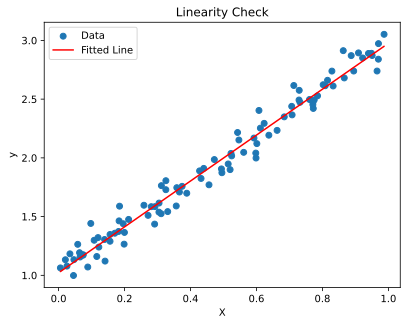

In [5]:
# Load your dataset
# df = pd.read_csv('your_dataset.csv')

# For illustration purposes, we create a sample dataset
np.random.seed(42)
X = np.random.rand(100)
y = 2 * X + 1 + 0.1 * np.random.randn(100)
df = pd.DataFrame({'X': X, 'y': y})

# Fit the linear regression model
X = sm.add_constant(df['X'])
model = sm.OLS(df['y'], X).fit()

# Assumption 1: Linearity
# Use a scatter plot and the fitted values to visually inspect linearity
plt.scatter(df['X'], df['y'], label='Data')
plt.plot(df['X'], model.fittedvalues, color='red', label='Fitted Line')
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linearity Check')
plt.show();

---

### Homoscedasticity

This assumes homoscedasticity, which is the same **variance** within our error terms. Heteroscedasticity, the violation of homoscedasticity, occurs when we don’t have an even **variance** across the error terms.

**Why it can happen:** Our model may be giving too much weight to a subset of the data, particularly where the error variance was the largest.

**What it will affect:** Significance tests for coefficients due to the standard errors being biased. Additionally, the confidence intervals will be either too wide or too narrow.

**How to detect it:** Plot the residuals and see if the variance appears to be uniform.

**How to fix it:** Heteroscedasticity (can you tell I like the *scedasticity* words?) can be solved either by using [weighted least squares regression](https://en.wikipedia.org/wiki/Least_squares#Weighted_least_squares) instead of the standard OLS or transforming either the dependent or highly skewed variables. Performing a log transformation on the dependent variable is not a bad place to start.

---

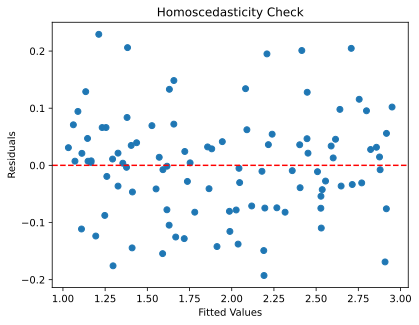

In [6]:
# Assumption 2: Homoscedasticity
# Use a scatter plot of residuals vs. fitted values to visually inspect homoscedasticity
residuals = model.resid
plt.scatter(model.fittedvalues, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Homoscedasticity Check')
plt.show();

### Normality of the Error Terms

More specifically, this assumes that the error terms of the model are **normally distributed**. Linear regressions other than [Ordinary Least Squares (OLS)](https://en.wikipedia.org/wiki/Ordinary_least_squares) may also assume normality of the predictors or the label, but that is not the case here.

**Why it can happen:** This can actually happen if either the predictors or the label are significantly non-normal. Other potential reasons could include the linearity assumption being violated or outliers affecting our model.

**What it will affect:** A violation of this assumption could cause issues with either shrinking or inflating our confidence intervals.

**How to detect it:** There are a variety of ways to do so, but we’ll look at both a histogram and the p-value from the Anderson-Darling test for normality.

**How to fix it:** It depends on the root cause, but there are a few options. Nonlinear transformations of the variables, excluding specific variables (such as long-tailed variables), or removing outliers may solve this problem.

---

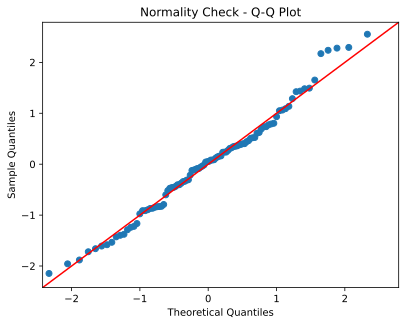

Shapiro-Wilk Test: ShapiroResult(statistic=0.9846267871943117, pvalue=0.29841614058046384)


In [7]:
# Assumption 3: Normality of error terms
# Use a Q-Q plot to visually inspect normality
sm.qqplot(residuals, line='45', fit=True)
plt.title('Normality Check - Q-Q Plot')
plt.show();

# Alternatively, use the Shapiro-Wilk test for normality
# (Null hypothesis: The residuals are normally distributed)
shapiro_test = stats.shapiro(residuals)
print('Shapiro-Wilk Test:', shapiro_test)

### No Autocorrelation between Error Terms

This assumes no autocorrelation of the error terms. Autocorrelation being present typically indicates that we are missing some information that should be captured by the model.

**Why it can happen:** In a time series scenario, there could be information about the past that we aren’t capturing. In a non-time series scenario, our model could be systematically biased by either under or over predicting in certain conditions. Lastly, this could be a result of a violation of the linearity assumption.

**What it will affect:** This will impact our model estimates.

**How to detect it:** We will perform a [Durbin-Watson test](https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic) to determine if either positive or negative correlation is present. Alternatively, you could create plots of residual autocorrelations.

**How to fix it:** A simple fix of adding lag variables can fix this problem. Alternatively, interaction terms, additional variables, or additional transformations may fix this.

---

We can use the some tests such as Durbin-Watson test to check for autocorrelation. The null hypothesis of the Durbin-Watson test is that there is no autocorrelation. The test statistic is a number between 0 and 4. The closer the test statistic is to 0, the more positive autocorrelation there is. The closer the test statistic is to 4, the more negative autocorrelation there is. A value of 2 indicates no autocorrelation.

Durbin-Watson statistic: 2.2849976037296673


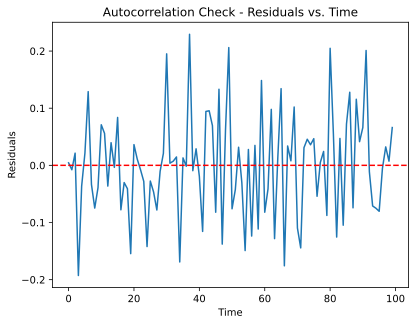

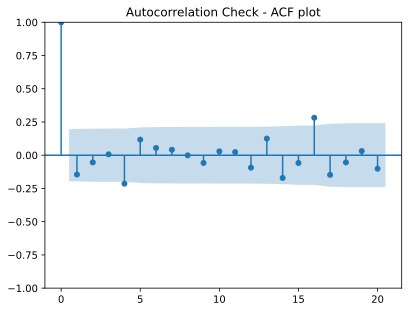

In [8]:
# Assumption: No autocorrelation in residuals
# Use the Durbin-Watson test to check for autocorrelation
# (Null hypothesis: No autocorrelation in the residuals)
durbin_watson_stat = durbin_watson(model.resid)
print('Durbin-Watson statistic:', durbin_watson_stat)

# A value close to 2 indicates no autocorrelation,
# while values < 2 or > 2 indicate positive or negative autocorrelation, respectively.

# Alternatively, you can use a plot of residuals vs. time
residuals = model.resid
plt.plot(residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Autocorrelation Check - Residuals vs. Time')
plt.show()

# You can also use the ACF (Autocorrelation Function) plot from the statsmodels library
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residuals, lags=20, title='Autocorrelation Check - ACF plot')
plt.show();

### Multicollinearity among Predictors

This assumes that the predictors used in the regression are not correlated with each other. This won’t render our model unusable if violated, but it will cause issues with the interpretability of the model. This is why in the previous section, we need to make sure that the 3 variables, **square feet, number of bedrooms, age of house** are not highly correlated with each other, else additive effects may happen.

**Why it can happen:** A lot of data is just naturally correlated. For example, if trying to predict a house price with square footage, the number of bedrooms, and the number of bathrooms, we can expect to see correlation between those three variables because bedrooms and bathrooms make up a portion of square footage.

**What it will affect:** Multicollinearity causes issues with the interpretation of the coefficients. Specifically, you can interpret a coefficient as “an increase of 1 in this predictor results in a change of (coefficient) in the response variable, holding all other predictors constant.” This becomes problematic when multicollinearity is present because we can’t hold correlated predictors constant. Additionally, it increases the standard error of the coefficients, which results in them potentially showing as statistically insignificant when they might actually be significant.

**How to detect it:** There are a few ways, but we will use a heatmap of the correlation as a visual aid and examine the [variance inflation factor (VIF)](https://en.wikipedia.org/wiki/Variance_inflation_factor).

**How to fix it:** This can be fixed by other removing predictors with a high variance inflation factor (VIF) or performing dimensionality reduction.

---

Let's create another dataset to see how to detect multicollinearity.

VIF:


,Features,VIF
0,X1,12.928109
1,X2,12.534023
2,X3,8.184352


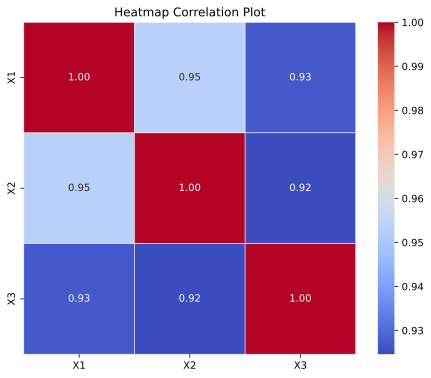

In [9]:
# Assumption 5: No perfect multicollinearity
# For a simple linear regression, multicollinearity is not an issue.
# For multiple linear regression, check the variance inflation factor (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load your multiple linear regression dataset
# df_multi = pd.read_csv('your_multi_dataset.csv')

# For illustration purposes, we create a sample dataset with three variables
np.random.seed(42)
X1 = np.random.rand(100)
X2 = X1 + 0.1 * np.random.randn(100)
X3 = 0.5 * X1 + 0.5 * X2 + 0.1 * np.random.randn(100)
y_multi = 2 * X1 + 3 * X2 - 1 * X3 + 1 + 0.1 * np.random.randn(100)
df_multi = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'y': y_multi})

# Fit the multiple linear regression model
X_multi = sm.add_constant(df_multi[['X1', 'X2', 'X3']])
model_multi = sm.OLS(df_multi['y'], X_multi).fit()

# Assumption: No perfect multicollinearity
# Check the variance inflation factor (VIF) for each independent variable
vif = pd.DataFrame()
vif['Features'] = ['X1', 'X2', 'X3']
vif['VIF'] = [variance_inflation_factor(X_multi.values, i + 1) for i in range(len(vif['Features']))]
print('VIF:')
display(vif)

# Use a heatmap to visualize the correlation between variables
corr_matrix = df_multi[['X1', 'X2', 'X3']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', cbar=True, square=True, fmt='.2f', linewidths=.5)
plt.title('Heatmap Correlation Plot')
plt.show();

## Feature Scaling

> Do we need to scale the features before fitting a linear regression model?

This question is often asked in the context of multiple linear regression, but it is actually a more general question about the use of [standardization](https://en.wikipedia.org/wiki/Feature_scaling#Standardization) and [normalization](https://en.wikipedia.org/wiki/Feature_scaling#Normalization) in machine learning.

[Reference](https://stats.stackexchange.com/questions/29781/when-conducting-multiple-regression-when-should-you-center-your-predictor-varia)

The scale and location of the explanatory variables does not affect the *validity* of the regression model in any way.

Consider the model $y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \varepsilon$. If you scale $x_1$ by a factor $a$, the model becomes $y = \beta_0 + \beta_1 a x_1 + \beta_2 x_2 + \beta_3 x_3 + \epsilon$. The coefficients $\beta_1, \beta_2, \beta_3$ are not affected by this scaling. The reason is that these are the slopes of the fitting surface - how much the surface changes if you change $x_1, x_2, x_3$ one unit. This does not depend on location. (The intercept $\beta_0$ does depend on location, but this is not a problem.)

Let's see for ourselves.

Let's look at the feature $x_1$ and its corresponding coefficient $\hat{\beta}_1$.

We claim that scaling $x_1$ with a factor $a$ scales $\hat{\beta}_1$by a factor $\frac{1}{a}$. To see this, note that

$$
\hat{\beta}_1(x_1)=\dfrac{\sum_{n=1}^{N}\left(x_{1}^{(n)}−\bar{x}_1\right)\left(y^{(n)}−\bar{y}\right)}{\sum_{n=1}^{N}\left(x_{1}^{(n)}−\bar{x}_1\right)^2}
$$

Thus

$$
\hat{\beta}_1(ax_1)=\dfrac{\sum_{n=1}^{N}\left(ax_{1}^{(n)}−a\bar{x}_1\right)\left(y^{(n)}−\bar{y}\right)}{\sum_{n=1}^{N}\left(ax_{1}^{(n)}−a\bar{x}_1\right)^2}=\dfrac{\sum_{n=1}^{N}\left(x_{1}^{(n)}−\bar{x}_1\right)\left(y^{(n)}−\bar{y}\right)}{\sum_{n=1}^{N}\left(x_{1}^{(n)}−\bar{x}_1\right)^2}=\dfrac{1}{a}\hat{\beta}_1(x_1)
$$

Thus, scaling simply corresponds to scaling the corresponding slopes. Because if we scale **square feet (**$x_1$) by a factor of $\frac{1}{10}$, then if the original $\hat{\beta}_1$
was **square feet** is 100, then the above shows that the new $\hat{\beta}_1$ will be multiplied by 10, becoming 1000, therefore, the interpretation of the coefficients did not change.

However, if you are using Gradient Descent (an optimization algorithm) in Regression, then centering, or scaling the variables, may prove to be faster for convergence.


---

## Model Inference

Say we have obtained the following estimates for the coefficients of the multiple linear regression model:

$$
\hat{\beta}_0 = 92451, \hat{\beta}_1 = 139, \hat{\beta}_2 = -8621, \hat{\beta}_3 = -81
$$

and so our estimated model $\hat{y}: = \hat{h}(\mathbf{x})$ of the ground truth $y:= f(\mathbf{x})$ is:

$$
\hat{y} = 92451+139x_1-8621x_2-81x_3
$$

where

- $x_1 = \text{square feet}$,
- $x_2 = \text{number of bed rooms}$,
- $x_3 = \text{age of house}$


The coefficient value signifies how much the mean of the dependent variable $y$ changes given a one-unit shift in the independent variable $x$ while **holding other variables in the model constant.** This property of holding the other variables constant is crucial because it allows you to assess the effect of each variable in isolation from the others.

For example, if we hold the number of bedrooms and age of house constant, then the coefficient of square feet is 139, which means that for every additional square foot, the price of the house increases by 139 dollars.

## Mean Squared Error is an Unbiased Estimator of the Variance of the Error

Mean Squared Error (MSE) is a commonly used metric for evaluating the performance of a regression model. It measures the average squared difference between the predicted values and the actual values. In the context of linear regression, the MSE is an unbiased estimator of the variance of the error term. This means that, on average, the MSE is equal to the true variance of the error term in the population.

The MSE is defined as:

$$
\begin{aligned}
MSE(\boldsymbol{\beta}) := \hat{\mathcal{J}}(\boldsymbol{\beta}) &= \frac{1}{N} \sum_{n=1}^{N} \left(y^{(n)} - \hat{y}^{(n)}\right)^2 \\
&= \frac{1}{N} \sum_{n=1}^{N} \left(y^{(n)} - \left(\beta_0 + \beta_1 x_1^{(n)} + \ldots \beta_D x_D^{(n)}\right)\right)^2
\end{aligned}
$$

Where:

- $N$ is the number of observations.
- $y^{(n)}$ is the actual value of the dependent variable for observation $n$.
- $\hat{y}^{(n)}$ is the predicted value of the dependent variable for observation $n$.

In the context of linear regression, the error term is defined as the difference between the actual value and the predicted value:

$$
\varepsilon^{(n)} = y^{(n)} - \hat{y}^{(n)} = y^{(n)} - \left(\beta_0 + \beta_1 x_1^{(n)} + \ldots \beta_D x_D^{(n)}\right)
$$

The variance of the error term is:

$$
\sigma^2 = \frac{1}{N} \sum_{n=1}^{N} \left(\varepsilon^{(n)}\right)^2
$$

However, in practice, we do not know the true values of the parameters $\beta_0, \beta_1, \ldots, \beta_D$.
We estimate them using the sample data $\mathcal{S}$, which gives us the predicted values $\hat{y}^{(n)} = \beta_0 + \beta_1 x_1^{(n)} + \ldots \beta_D x_D^{(n)}$.
Therefore, the estimated variance of the error term is:

$$
\hat{\sigma}^2 = \frac{1}{N} \sum_{n=1}^{N} \left(y^{(n)} - \hat{y}^{(n)}\right)^2 = \hat{\mathcal{J}}(\hat{\boldsymbol{\beta}}) = MSE(\hat{\boldsymbol{\beta}})
$$

The MSE is an unbiased estimator of the variance of the error term because the expected value of the MSE is equal to the true variance of the error term:

$$
\mathbb{E}[MSE(\hat{\boldsymbol{\beta}})] = \mathbb{E}\left[\frac{1}{N} \sum_{n=1}^{N} \left(y^{(n)} - \hat{y}^{(n)}\right)^2\right] = \frac{1}{N} \sum_{n=1}^{N} \mathbb{E}\left[\left(y^{(n)} - \hat{y}^{(n)}\right)^2\right] = \frac{1}{N} \sum_{n=1}^{N} \sigma^2 = \sigma^2
$$

This property is important because it ensures that the MSE provides an accurate measure of the model's performance. If the MSE were a biased estimator, it would consistently overestimate or underestimate the true variance of the error term, leading to incorrect inferences about the model's performance. Since the MSE is an unbiased estimator, it provides a reliable estimate of the model's error variance, making it a useful metric for model evaluation and comparison.


## Estimated Coefficients are Multivariate Normally Distributed

With the assumption that the error term $\varepsilon \mid X \sim N[0, \sigma^2\mathbf{I}]$, we derive the weaker condition[^weaker-condition]  of $\varepsilon \sim N[0, \sigma^2\mathbf{I}]$. It is necessary to make this assumption for us to ***know the distribution of*** $\hat{\boldsymbol{\beta}}$, because without this assumption, we will be at a loss of what distribution $\hat{\boldsymbol{\beta}}$ can take on. We claim first that since $\boldsymbol{\varepsilon}|\mathbf{X} \sim N[0, \sigma^2\mathbf{I}]$ follows a multivariate normal distribution of mean $0$ and variance $\sigma^2\mathbf{I}$, then it implies that $\hat{\boldsymbol{\beta}}$ also follows a multivariate normal distribution of mean $\boldsymbol{\beta}$ and variance $\sigma^2(\mathbf{X}^T\mathbf{X})^{-1}$.

To justify this, we need to recall the variance-covariance matrix for $\hat{\boldsymbol{\beta}}$ to have variance $\sigma^2(\mathbf{X}^T\mathbf{X})^{-1}$\footnote{it is necessary to know the mean and variance of $\boldsymbol{\varepsilon}$ in order to find the variance-covariance of $\hat{\boldsymbol{\beta}}$.}, and earlier on we also established the proof of $\hat{\boldsymbol{\beta}}$ being an unbiased estimator, which simply states that $\mathrm{E}[\hat{\boldsymbol{\beta}}] = \boldsymbol{\beta}$. So we know  the mean and variance of our OLS estimators $\hat{\boldsymbol{\beta}}$, but one last question, why does $\boldsymbol{\varepsilon}$ taking on a multivariate normal distribution imply that $\hat{\boldsymbol{\beta}}$ must also follow a multivariate normal distribution?

This is a consequence of that $\hat{\boldsymbol{\beta}}$ is a linear estimator, recall that we are treating $\boldsymbol{\beta}$ and $\mathbf{X}$ as constant and non-stochastic, and consequently $\hat{\boldsymbol{\beta}}$ is linear function of the error vector $\boldsymbol{\varepsilon}$.

$$
\hat{\boldsymbol{\beta}} = \boldsymbol{\beta} + (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\boldsymbol{\varepsilon} = g(\boldsymbol{\varepsilon})
$$

And using the property that ***a linear transform of a normal random variable is normal***, we can easily see that $\hat{\boldsymbol{\beta}}$ must be normal as well since $\hat{\boldsymbol{\beta}}$ is a linear transformation of $\boldsymbol{\varepsilon}$.

Thus so far we established the least squares parameters $\hat{\boldsymbol{\beta}}$ is normally distributed with mean $\boldsymbol{\beta}$ and variance $\sigma^2(\mathbf{X}^T\mathbf{X})^{-1}$. More formally, we say that $\hat{\boldsymbol{\beta}}$ follows a **multi-variate normal distribution** because $\hat{\boldsymbol{\beta}}$ is a random vector, the distinction is that the variance of $\hat{\boldsymbol{\beta}}$ is now a variance-covariance matrix instead of just a variance vector. But recall we do not know the real value of $\sigma^2$ and therefore we replace $\sigma^2$ with the **unbiased variance estimator of the error variance, which we define and name it to be the Mean Squared Error (MSE)** It is useful to remind yourself that we are learning ML, although MSE has a slightly different formula from the MSE in sklearn, the end goal is the same, refer to [Confusion on MSE](https://stats.stackexchange.com/questions/448005/confusion-on-mean-squared-error-for-regression).


## Assessing the Accuracy of the Coefficient Estimates

This section is adapted from An Introduction to Statistical Learning {cite}`james_witten_hastie_tibshirani_2022`.

Recall that we are ultimately always interested in drawing conclusions about the population, not the particular sample we observed. This is an important sentence to understand, the reason we are testing our hypothesis on the population parameter instead of the estimated parameter is because we are interested in knowing our real population parameter, and we are using the estimated parameter to provide some statistical gauge. In the Simple Linear Regression setting, we are often interested in learning about the population intercept $\beta_0$ and the population slope $\beta_1$. As you know, **confidence intervals and hypothesis tests** are two related, but different, ways of learning about the values of population parameters. Here, we will learn how to calculate confidence intervals and conduct different hypothesis tests for both $\beta_0$ and $\beta_1$.We turn our heads back to the SLR section, because when we ingest and digest concepts, it is important to start from baby steps first and generalize.

As a continuation of our running example in the univariate setting, we have 1 predictor which is the
area of the house, in square feet, and we are interested in learning about the population intercept $\beta_0$ and the population slope $\beta_1$.

As an example, assumed we have already learned that the estimated intercept $\hat{\beta}_0$ and the estimated slope $\hat{\beta}_1$ are given by:

$$
\beta_0 = 114418, \beta_1 = 962
$$ (eq-estimated-intercept-slope-linear-regression-univariate-1)

where we round the numbers to the nearest integer for simplicity.

Estimated intercept: 114418.53
Estimated slope: 961.70


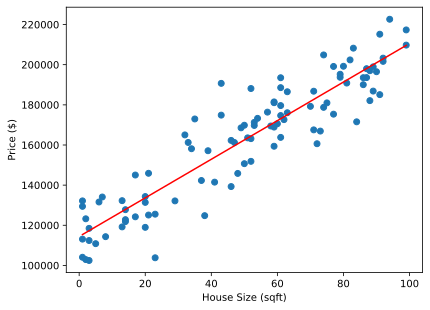

In [10]:
X = data['House Size (sqft)']
y = data['Price ($)']
coefficients = np.polyfit(X, y, 1)
slope, intercept = coefficients[0], coefficients[1]
print(f'Estimated intercept: {intercept:.2f}')
print(f'Estimated slope: {slope:.2f}')

plt.scatter(X, y)
plt.plot(np.unique(X), np.poly1d(coefficients)(np.unique(X)), color='red')
plt.xlabel('House Size (sqft)')
plt.ylabel('Price ($)')
plt.show()

As we can see above from both the fitted plot and the OLS coefficients, there does seem to be a linear relationship between the two. Furthermore, the OLS regression line's equation can be easily calculated and given by:

$$
\hat{y} = \beta_0 + \beta_1x_1 = 114418 + 962x_1
$$ (eq-estimated-intercept-slope-linear-regression-univariate-2)

where $x_1$ is the area of the house in square feet.

And so we know the **estimated** slope parameter $\hat{\beta_1}$ is $962$, and apparently there exhibits a "relationship" between $x_1$ and $y$. Remember, if there is no relationship, then our optimal **estimated** parameter $\hat{\beta}_1$ should be 0, as a coefficient of $0$ means that $x_1$ and $y$ has no relationship (or at least in the linear form, the same however, cannot be said for non-linear models!). But be careful, although we can be certain that there is a relationship between `house area` and the `sale price`, but it is only **limited** to the $100$ training samples that we have!

In fact, we want to know if there is a relationship between the ***population parameter*** of all of the `house area` and its corresponding `sale price` in the whole **population (country)**. More concretely, we want to know if the ***true population slope*** is close to the estimated slope parameter $\hat{\beta}_1$ that we have obtained from our sample.

It follows that we also want to ascertain that the **true population slope** $\beta_1$is **unlikely** to be 0 as well. Note that $0$ is a common benchmark we use in linear regression, but it, in fact can be any number. This is why we have to draw **inferences** from $\hat{\beta}_1$ to make substantiate conclusion on the true population slope $\beta_1$.

Let us formulate our question/hypothesis by asking the question: **Do our `house area` and `sale price` exhibit a true linear relationship in our population? Can we make inferences of our true population parameters based on the estimated parameters (OLS estimates)?**

Thus, we can use the infamous scientific method **Hypothesis Testing** by defining our null hypothesis and alternate hypothesis as follows:

- Null Hypothesis $H_0$: $\beta_1=0$
- Alternative Hypothesis $H_1$: $\beta_1\neq 0$

Basically, the null hypothesis says that $\beta_1=0$, indicating that there is no relationship between $X$ and $y$. Indeed, if $\beta_1=0$, our original model reduces to $y=\beta_0+\varepsilon$, and this shows $X$ does not depend on $y$ at all. To test the **null hypothesis**, we **instead** need to determine whether $\hat{\beta}_1$, our OLS estimate for $\beta_1$, is ***sufficiently far from 0*** so that we are **confident** that the real parameter $\beta_1$ is non-zero. Note the distinction here that we emphasized that we are performing a hypothesis testing on the **true population parameter** but we depend on the value of the **estimate of the true population parameter since we have no way to know the underlying true population parameter.**

---

### Standard Error

Now here is the intuition, yet again, we need to gain an understanding first before we go into further mathematical details. We already established subtly that even if we can easily calculate $\hat\beta_1$, and it turns out to be non-zero, how can we feel **"safe"** that our true parameter $\beta_1$ is also non-zero? Well if you think deeper, it all boils down to whether our $\hat{\beta_1}$ is a **good estimate** of $\beta_1$; and this can be quantified by checking the standard error of $\hat{\beta_1}$. By definition, we should remember the standard error of $\hat{\beta_1}$ means the amount of dispersion of the various $\hat\beta_1$ around its mean (recall the mean of $\hat\beta_1$ is $\beta_1$). So if $\text{SE}(\hat{\beta_1})$ is small, this means $\hat{\beta_1}$ does not vary much around its mean and recall that the mean of $\hat{\beta_1}$ is none other than $\beta_1$ due to the unbiasedness property of OLS estimator; consequently, it is quite "safe" to say that which ever sample you take from the population, the $\hat\beta_1$ you calculated should not fluctuate much from the mean $\beta_1$, indicating that $\beta_1$ and $\hat\beta_1$ are quite "close to each other".

But here is the catch yet again, how small is small? If for example, $\hat{\beta_1} = 0.5$ but if $\text{SE}(\hat{\beta_1}) = 0.499$, then this standard error is not small relative to the value of $\hat{\boldsymbol{\beta}}$. $\hat{\beta_1}$. One should understand in a rough sense that the standard error of $\hat{\boldsymbol{\beta}}$ is the **average amount that this particular $\hat{\boldsymbol{\beta}}$ differs from the actual value of $\boldsymbol{\beta}$.** So if for example, the above example says that the average amount that this $\hat{\beta_1}$ differs from the real $\beta_1$ is 0.499, and this is not very promising because it means that our real $\beta_1$ could be $0.5-0.499 = 0.001$, which is very close to $0$, we do not really feel safe about our $\hat{\beta_1}$ since it can still suggest that our real $\beta_1$ is near 0 and we cannot reject the null hypothesis that $\beta_1 = 0$.

Conversely, if our standard error of $\hat{\beta_1}$ is very large, say equals to 10000, this does not necessarily mean our $\hat{\beta_1}$ is an inaccurate estimate of $\beta_1$, because if our $\beta_1$ is so large relative to 10000, say our $\beta_1 = 1000000000000$, then this standard error is small relatively and we still have strong evidence to reject the null hypothesis. In a similar vein as the previous example, on average, we should expect our $\beta_1$ to be around $1000000000000 \pm 10000$, which is nowhere close to 0.

So we also must find a metric to calculate how small is small, or conversely, how big is big. Therefore, to understand that if $\text{SE}(\hat{\beta_1}) <<< \hat{\beta_1}$, that is, standard error of the estimator $\hat{\beta_1}$ is way smaller than $\hat{\beta_1}$, then it is safe to say that our $\hat{\beta_1}$ provides strong evidence that the real parameter is non-zero as well.

For example, if $\hat{\beta_1} = 0.5$ and $\text{SE}(\hat{\beta_1}) = 0.0001$, then even though $\hat{\beta_1}$ is quite near $0$, we can still feel confident to say that the real parameter $\beta_1$ is not 0, simply because our estimate $\hat{\beta_1}$ has such a small standard error/variation that it is very unlikely for our $\beta_1$ to be 0.


What I have described above is merely an intuition, talk is cheap and we need to use scientific methods to quantify it. To quantify what I have said above, we use t-statistics to calculate the number of standard deviations that $\hat{\beta_1}$ is away from $0$. In fact the formula allows any number, not limited to 0.

### T-Statistics

In statistics, the **t-statistic** is the ratio of the difference of the **estimated** value of a true population parameter from its **hypothesized** value to its **standard error**. A good intuitive of [explanation of t-statistics can be read here](https://blog.minitab.com/blog/statistics-and-quality-data-analysis/what-is-a-t-test-and-why-is-it-like-telling-a-kid-to-clean-up-that-mess-in-the-kitchen).

Let $\hat{\boldsymbol{\beta}}$ be an estimator of $\boldsymbol{\beta}$ in some statistical model. Then a **t-statistic** for this parameter $\boldsymbol{\beta}$ is any quantity of the form

$$t_{\hat{\boldsymbol{\beta}}} = \dfrac{\hat{\boldsymbol{\beta}} - \boldsymbol{\beta}_H}{\text{SE}(\hat{\boldsymbol{\beta}})}$$

where $\boldsymbol{\beta}_H$ is the value we want to test in the hypothesis. By default, statistical software sets $\boldsymbol{\beta}_H = 0$.

In the regression setting, we further take note that the **t-statistic** for each individual coefficient $\hat{\beta}_i$ is given by

$$t_{\hat{\boldsymbol{\beta}}i} = [t_{\hat{\boldsymbol{\beta}}}]_{(i+1) \times (i+1)}$$

***If our null hypothesis is really true, that*** $\beta_1=0$***, then if we calculate our t-value to be 0, then we can understand it as the number of standard deviations that*** $\hat{\beta}_1$ ***is 0, which means that*** $\hat{\beta}_1$ ***is 0. This might be hard to reconcile at first, but if we see the formula of the t-statistics, and that by definition we set*** $\beta_H=0$, then it is apparent that if $t_{\hat{\beta}}=0$, it forces the formula to become $t_{\hat{\beta}}=0=\dfrac{\hat{\beta}-0}{\text{SE}(\hat{\beta})} \Longrightarrow \hat{\beta}=0$ ; even more concretely with an example, we replace $\beta_{H}$ with our favorite **true population parameter** $\beta_1$ and $\hat{\beta}$ with $\hat{\beta}_1$, then it just means that if $\beta_1$ were really $0$, i.e. no relationship of $y$ and $x_1$, and if we also get $t_{\hat{\beta}_1}$to be 0 as well (To re-explain this part as a bit cumbersome). In which case we accept the null hypothesis; on the other hand, if our t-value is none-zero, it means that $\hat{\beta}_1 \neq 0$.

Consequently, we can conclude that greater the magnitude of $|t|$ ($t$ can be either positive or negative), the greater the evidence to reject the null hypothesis. The closer $t$ is to 0, the more likely there isn’t a significant evidence to reject the null hypothesis.

#### Implementing T-Statistics

To find the t-value of $\hat{\beta_1}$, we need to first know what is the standard error of $\hat{\beta_1}$, which is $\text{SE}(\hat{\mathbf{\beta_1}})$. The formula is given by

$$
\text{SE}(\hat{\beta_1}) = \sqrt{\sigma^2(\mathbf{X}^T\mathbf{X})^{-1}}
$$

But since we do not know the value of the population variance $\sigma^2$ of the error term, we estimate it with

$$
\hat{\sigma}^2 = \dfrac{\text{Residual Sum of Squares (RSS)}}{N - D - 1}
$$

where $N$ is the number of samples, $D$ is the number of features.

The python code is implemented as follows, we will use sklearn's LinearRegression to find the parameters $\hat{\beta_0}$ and $\hat{\beta_1}$, and then we will use the formula above to find the standard error of $\hat{\beta_1}$, and then we will use the formula of t-statistics to find the t-value of $\hat{\beta_1}$.

In [11]:
X = X.to_numpy()
X = X.reshape(-1, 1)
y = y.to_numpy()

N, D = X.shape
print(f"Number of samples: {N}")
print(f"Number of features: {D}")

X_with_intercept = np.hstack((np.ones((N, 1)), X))
print(X_with_intercept.shape)

# Instantiate and fit the LinearRegression model
lr = LinearRegression()
lr.fit(X, y)

# Predict using the fitted model
y_pred = lr.predict(X)

# Compute the residual sum of squares (RSS)
rss = np.linalg.norm(y - y_pred) ** 2
# Compute the sigma square estimate
sigma_square_hat = rss / (N - (D + 1))
# Compute the variance-covariance matrix
var_beta_hat = sigma_square_hat * np.linalg.inv(np.dot(X_with_intercept.T, X_with_intercept))

# Print the standard errors and t-values for each coefficient
for i in range(D + 1):
    standard_error = var_beta_hat[i, i] ** 0.5   # standard error for beta_0 and beta_1
    print(f"Standard Error of (beta_hat[{i}]): {standard_error}")

    # Get the coefficient value (beta_hat)
    coef_value = lr.intercept_ if i == 0 else lr.coef_[0]
    t_values = coef_value / standard_error
    print(f"t_value of (beta_hat[{i}]): {t_values}")

    print("━" * 60)
    print("━" * 60)

Number of samples: 100
Number of features: 1
(100, 2)
Standard Error of (beta_hat[0]): 2442.4808292051985
t_value of (beta_hat[0]): 46.845211452439884
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Standard Error of (beta_hat[1]): 41.81741692793702
t_value of (beta_hat[1]): 22.997689705070346
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


Well, we are only interested in the t-value of $\hat{\beta_1}$, which shows a value of 22. Quoting from [the author Jim Frost's book, he mentioned that](https://statisticsbyjim.com/hypothesis-testing/t-tests-t-values-t-distributions-probabilities/) the tricky thing about t-values is that they are a unitless statistic, which makes them difficult to interpret on their own. We performed a t-test and it produced a t-value of 38.36. What does this t-value mean exactly? We know that the sample mean doesn’t equal the null hypothesis value because this t-value doesn’t equal zero. However, we don’t know how exceptional our value is if the null hypothesis is correct.

This is why we need to look at the P-values of the t-test. But before that, we look at t-distributions first.

### T-Distributions

How T-distribution is formed:

1. Define our null and alternative hypothesis. In Simple Linear Regression, we simply set:

    $$
    \begin{aligned}
    & H_0: &\beta_1 &= 0 \\
    & H_{A}: &\beta_1 &\neq 0
    \end{aligned}
    $$


2. Determine the test statistic that is most suitable for this parameter $\beta_1$. Note that $\beta_1$ is actually a constant and not a random variable, and we cannot know the distribution of $\beta_1$ anyways since population is unknown. However, we can make use of the OLS estimator of $\beta_1$ to draw inferences about it. So although we do not know $\beta_1$ we are able to derive the sampling distribution of $\hat{\beta_1}$ which we have shown in the first section to be:

    $$
    \hat{\boldsymbol{\beta}} \sim N\left(\boldsymbol{\beta},  \hat{\sigma}^2(\mathbf{X}^T\mathbf{X})^{-1}\right)
    $$


We could jolly well define $\hat{\beta_1}$ to be our test statistic and calculate $P(\hat{\beta_1} \geq B_H)$ where $B_H$ is the hypothesis we want to test, if not for the fact that we do not even know the value of $\sigma^2$ - which we desperately need because it appeared in the variance of $\hat{\beta_1}$. So this is the reason why we need to use an equivalent test statistic:

$$
t_{\hat{\mathbf{\beta_1}}} = \dfrac{\hat{\mathbf{\beta_1}} - \mathbf{\beta_1}_H}{\text{SE}(\hat{\mathbf{\beta_1}})} \sim t(df)
$$

This means that if our $\hat{\beta_1}$ follows a normal distribution of $\hat{\boldsymbol{\beta}} \sim N\left(\boldsymbol{\beta},  \hat{\sigma}^2(\mathbf{X}^T\mathbf{X})^{-1}\right)$, then an equivalent distribution is $t_{\hat{\mathbf{\beta_1}}} \sim t(df)$.

So it is clear that for any $a, b \in \mathbb{R}$, finding $P(a \leq \hat{\beta_1} \leq b)$ is the same as finding

$$
\mathbb{P}\left(\dfrac{a}{\text{SE}(\hat{\beta_1})} \leq t_{\hat{\mathbf{\beta_1}}} \leq \dfrac{b}{\text{SE}(\hat{\beta_1})} \right)
$$


So finally, we have formed a sampling distribution of t-statistics, hinged on the assumption that ***our null hypothesis is true, $\beta_1 = 0$ (this is important).***

[Jim Statistics](https://statisticsbyjim.com/hypothesis-testing/t-tests-t-values-t-distributions-probabilities/) provides an intuitive idea.

### P-Values

We use the resulting test statistic to calculate the p-value. As always, the p-value is the answer to the question "how likely is it that we’d get a test statistic $t_{\hat{\boldsymbol{\beta}}}$ as extreme as we did if the null hypothesis were true?" The p-value is determined by referring to a t-distribution with $m-(n+1) = m-2$ degrees of freedom where we recall that $m$ is the number of data, and $n$ is the number of variables. The $n+1$ is because we are actually fitting 2 parameters, so we add on 1 intercept term which has a dummy variable $x_0$.




Finally, we make a decision:


1. If the p-value is smaller than the significance level $\alpha$, we reject the null hypothesis in favor of the alternative. We conclude "there is sufficient evidence at the $\alpha$ level to conclude that there is a linear relationship in the population between the predictor x and response y."


2. If the p-value is larger than the significance level $\alpha$, we fail to reject the null hypothesis. We conclude "there is not enough evidence at the $\alpha$ level to conclude that there is a linear relationship in the population between the predictor x and response y."




Let us implement our p-values.

In [12]:
X = X.reshape(-1, 1)
N, D = X.shape

lr = LinearRegression()
lr.fit(X, y)

y_pred = lr.predict(X)

X_with_intercept = np.hstack((np.ones((N, 1)), X))

# RSE = sqrt(RSS/(m-n))
# thus, sigma square estimate is RSS/(m-n)
sigma_square_hat = np.linalg.norm(y - y_pred) ** 2 / (N - (D + 1))
var_beta_hat = sigma_square_hat * np.linalg.inv(np.dot(X_with_intercept.T, X_with_intercept))

ols_parameters = [lr.intercept_] + list(lr.coef_)

for i in range(D + 1):
    standard_error = var_beta_hat[i, i] ** 0.5   # standard error for beta_0 and beta_1
    print(f"Standard Error of (beta_hat[{i}]): {standard_error}")

    t_values = ols_parameters[i] / standard_error
    print(f"t_value of (beta_hat[{i}]): {t_values}")

    p_values = 1 - stats.t.cdf(abs(t_values), df=X.shape[0] - (X.shape[1] + 1))
    print(f"p_value of (beta_hat[{i}]): {p_values}")

    print("━" * 60)
    print("━" * 60)

Standard Error of (beta_hat[0]): 2442.4808292051985
t_value of (beta_hat[0]): 46.845211452439884
p_value of (beta_hat[0]): 0.0
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Standard Error of (beta_hat[1]): 41.81741692793702
t_value of (beta_hat[1]): 22.997689705070346
p_value of (beta_hat[1]): 0.0
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


We easily use python to calculate the statistics for us, as shown above.


Because the p-value is so small (usually less than $0.05$, this means that if our null hypothesis was actually true that $\beta_1 = 0$, then there is only a $0.0\%$ chance to get this $t = 38.348$ value. In other words, it is unlikely to observe such a substantial association between the predictor and the response due to chance, in the absence of any real association between the predictor and the response. We can reject the null hypothesis and conclude that $\beta_1$ does not equal 0. There is sufficient evidence, at the $\alpha = 0.05$ level, to conclude that there is a linear relationship in the population between house area and the sale price.



Similarly, we can see the p-value for $\hat{\beta_0}$ to be less than $0.05$ as well. Consequently, we conclude that $\beta_0 \neq 0$ and $\beta_1 \neq 0$.


Since the above is a self implemented function, it is always good to check with the statsmodels.api from python to check if I am correct.

In [13]:
OLS(y, X_with_intercept).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     528.9
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           2.81e-41
Time:                        01:14:23   Log-Likelihood:                -1082.2
No. Observations:                 100   AIC:                             2168.
Df Residuals:                      98   BIC:                             2174.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.144e+05   2442.481     46.845      0.000     1.1e+05    1.19e+05
x1           961.7040     41.817     22.998      0.000     878.719    1044.689
==============================================================================
Omnibus:                        0.135   Durbin-Watson:                   2.166
Prob(Omnibus):                  0.935   Jarque-Bera (JB):                0.038
Skew:                           0.047   Prob(JB):                        0.981
Kurtosis:                       2.992   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see the t and p values coincide.

### The Pandora Box of Confidence Intervals, P-values and Hypothesis Testing

The focus of this post is not to go into details on how to interpret the
coefficients using statistical methods. As I've mentioned, regression analysis in itself
can be one whole undergraduate module spanning more than 1 term/semester. To have a more
thorough understanding, I would recommend reading the regression chapter in An Introduction to Statistical Learning by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani.

---

## Time Complexity

Time Complexity is an important topic, you do not want your code to run for 1 billion years, and therefore, an efficient code will be important to businesses. That is also why Time Complexity questions are becoming increasingly popular in Machine Learning and Data Science interviews!

The Linear Algorithm that we used here simply uses matrix multiplication. We will also ignore the codes that are of constant time O(1). For example, `self.coef_=None` in the constructor is O(1) and we do not really wish to consider this in the *grand scheme of things.*

What is the really important ones are in code lines 37–40. Given X to be a m by n matrix/array, where m is the number of samples and n the number of features. In addition, y is a m by 1 vector. Refer to this [Wikipedia Page](https://en.wikipedia.org/wiki/Computational_complexity_of_mathematical_operations) for a handy helpsheet on the various time complexity for mathematical operations.

Line 37: `np.dot(X.T,X)` In the dot product, we transpose the m × n matrix to become n × m, this operation takes O(m × n) time because we are effectively performing two for loops. Next up is performing matrix multiplication, note carefully that `np.dot` between two 2-d arrays does not mean [dot product](https://stackoverflow.com/questions/3744094/time-and-space-complexity-of-vector-dot-product-computation#:~:text=Assuming%20that%20multiplication%20and%20addition,computed%2C%20i.e.%20ai%20*%20bi%20.), instead they are matrix multiplication, which takes O(m × n²) time. The output matrix of this step is n× n.

Line 38: Inverting a n × n matrix takes n³ time. The output matrix is n × n.

Line 39: Now we perform matrix multiplication of n × n and n × m, which gives O(m × n²), the output matrix is n × m.

Line 40: Lastly, the time complexity is O(m × n).

Adding them all up gives you O(2mn+2mn²+n³) whereby simple triangle inequality of mn<mn² implies we can remove the less dominant 2mn term. In the end, the run time complexity of this Linear Regression Algorithm using Normal Equation is O(n²(m+n)). However, you noticed that there are two variables in the bigO notation, and you wonder if we can further reduce the bigO notation to a single variable? Well, if the number of variables is small, which means n is kept small and maybe constant, we can reduce the time complexity to O(m), however, if your variables are increasing, then your time complexity will explode if n → ∞.


## References and Further Readings

- Mohri, Mehryar, Rostamizadeh Afshi and Talwalkar Ameet. Foundations of Machine Learning. The MIT Press, 2018.
- Murphy, Kevin P. "Chapter 21.3. K-Means Clustering." In Probabilistic Machine Learning: An Introduction. MIT Press, 2022.
- Hal Daumé III. "Chapter 3.4. K-Means Clustering." In A Course in Machine Learning, January 2017.
- Hal Daumé III. "Chapter 15.1. K-Means Clustering." In A Course in Machine Learning, January 2017.
- Bishop, Christopher M. "Chapter 9.1. K-Means Clustering." In Pattern Recognition and Machine Learning. New York: Springer-Verlag, 2016.
- James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. "Chapter 12.4.1. K-Means Clustering." In An Introduction to Statistical Learning: With Applications in R. Boston: Springer, 2022.
- Hastie, Trevor, Tibshirani, Robert and Friedman, Jerome. "Chapter 14.3. Cluster Analysis." In The Elements of Statistical Learning. New York, NY, USA: Springer New York Inc., 2001.
- Raschka, Sebastian. "Chapter 10.1. Grouping objects by similarity using k-means." In Machine Learning with PyTorch and Scikit-Learn.
- Jung, Alexander. "Chapter 8.1. Hard Clustering with K-Means." In Machine Learning: The Basics. Singapore: Springer Nature Singapore, 2023.
- Vincent, Tan. "Lecture 17a." In MA4270 Data Modelling and Computation.
- https://online.stat.psu.edu/stat462/
- [Statistics by Jim - Regression](https://statisticsbyjim.com/regression/)
    - [Interpreting MLR Coefficients and P-values](https://statisticsbyjim.com/regression/interpret-coefficients-p-values-regression/)
    - [Goodness of Fit and R-Squared](https://blog.minitab.com/en/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit)
    - [T-Test](https://blog.minitab.com/en/statistics-and-quality-data-analysis/what-is-a-t-test-and-why-is-it-like-telling-a-kid-to-clean-up-that-mess-in-the-kitchen)

- [Normal Equation (ML Wiki) Wholesome and Mathematically Rigorous](http://mlwiki.org/index.php/Normal_Equation)
- [Ordinary Least Squares Wikipedia](https://en.wikipedia.org/wiki/Ordinary_least_squares)
- [Linear Regression Assumptions by Jeff Macaluso from Microsoft](https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/)
- [Stanford's STATS203 class - Consider downloading them before it's gone](http://statweb.stanford.edu/~jtaylo/courses/stats203/)
- [Kaggle Linear Regression Assumptions](https://www.kaggle.com/shrutimechlearn/step-by-step-assumptions-linear-regression)
- [Linear Regression Additive Effects (PSU STATS462)](https://online.stat.psu.edu/stat462/node/164/)
- [Hands on Linear Regression](https://mylearningsinaiml.wordpress.com/concepts/regression/hands-on-linear-regression/)
- [Real Python Linear Regression](https://realpython.com/linear-regression-in-python/#multiple-linear-regression)
- [Normal Equation Derivation II](https://eli.thegreenplace.net/2014/derivation-of-the-normal-equation-for-linear-regression/)
- [Feature Scaling does not affect Linear Regressions' validity of Coefficients](https://stats.stackexchange.com/questions/29781/when-conducting-multiple-regression-when-should-you-center-your-predictor-varia)
- [Hypothesis Testing on Optimal Coefficients](https://online.stat.psu.edu/stat462/)
- [Conditional Mean and Expectation of Linear Regression](https://stats.stackexchange.com/questions/220507/linear-regression-conditional-expectations-and-expected-values/220509#220509)

[^dirac-delta]: A Dirac delta (function) is a function that is zero everywhere except at zero, where it is infinite. It is named after the physicist Paul Dirac.
[^weaker-condition]: Note that we have proved $\mathbb{E}[\boldsymbol{\varepsilon}] = \boldsymbol{0}$ and $\mathrm{Var}[\boldsymbol{\varepsilon}] = \sigma^2\mathbf{I}$ earlier by the Law of Iterated Expectation on $\boldsymbol{\varepsilon} \mid \mathbf{X}$, but it is necessary to further assume that $\boldsymbol{\varepsilon}$ itself has a normal distribution, or else we will not know the distribution of $\boldsymbol{\varepsilon}$.